In [1]:
library(Seurat)
library(ggplot2)
library(reshape2)
library(dplyr)
library('data.table')
library(stringr)
library(dplyr)
library(RColorBrewer)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following objects are masked from ‘package:reshape2’:

    dcast, melt




In [75]:
project <- Sys.getenv('WORKSPACE_NAMESPACE')
workspace <- Sys.getenv('WORKSPACE_NAME')
bucket <- Sys.getenv('WORKSPACE_BUCKET')
project
workspace
bucket

list.files(path = ".")

# use this one for first pass to merge dges
RAW_MATRICES <- "gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/*dge.txt.gz"

# download files to notebook's persistent disk
system("mkdir $(pwd)/RAW_MATRICES_ICH_ALL")
system(sprintf("gsutil -m cp %s $(pwd)/RAW_MATRICES_ICH_ALL/", RAW_MATRICES))


[1] "shalek-lab-firecloud"

[1] "MITMilkStudy_ShalekLab"

[1] "gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e"

[1] "alldata_matrix.rds"                     
 [2] "Analysis_Setup.ipynb"                   
 [3] "fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e"
 [4] "FreshvFrozen.ipynb"                     
 [5] "histogram_reads_per_cell.pdf"           
 [6] "Macrophage_MITMilkStudy.ipynb"          
 [7] "MAST_analysis_epithelial.ipynb"         
 [8] "MAST_analysis_macrophages.ipynb"        
 [9] "Monocytes_MIT_MilkStudy.ipynb"          
[10] "RAW_MATRICES_ICH_ALL"                   
[11] "RDS_Files"                              
[12] "seuratobj_alldata_unfilt.rds"           
[13] "seuratobj_alldata.rds"                  
[14] "summaryDt_milk_stage.txt"

In [76]:
list.files(path = "./RAW_MATRICES_ICH_ALL")

[1] "BM16_C_R1_Exp1_dge.txt.gz" "BM16_E_R1_Exp2_dge.txt.gz"
 [3] "BM16_F_R1_Exp1_dge.txt.gz" "BM16_F_R1_Exp2_dge.txt.gz"
 [5] "BM16_F_R2_Exp1_dge.txt.gz" "BM16_O_R1_Exp1_dge.txt.gz"
 [7] "BM16_S_R1_Exp2_dge.txt.gz" "BM17_C_R1_Exp1_dge.txt.gz"
 [9] "BM17_F_R1_Exp1_dge.txt.gz" "BM17_F_R1_Exp2_dge.txt.gz"
[11] "BM17_F_R2_Exp1_dge.txt.gz" "BM17_O_R1_Exp1_dge.txt.gz"

In [77]:
##Matrix Cleanup Function
merge.cleanup = function(data.mat = NULL){
  
  data.mat[is.na(data.mat)] <- 0
  
  rownames(data.mat) = data.mat$Row.names
  data.mat$Row.names=NULL
  
  return(data.mat)
  
}

##Merge SeqWell Matrices Function
merge.seqwell <- function(data.list=NULL){
  
  if(length(data.list)==1){
    return(data.list[[1]])
    
  }else if(length(data.list)==2){
    
    data.all = merge(as.matrix(data.list[[1]]), as.matrix(data.list[[2]]), by="row.names", all.x=TRUE, all.y=TRUE)
    data.all = merge.cleanup(data.all)
    return(data.all)
    
  }else if(length(data.list)>2){
    
    temp = round(length(data.list)/2)
    data.all = merge(merge.seqwell(data.list[1:temp]),
                     merge.seqwell(data.list[(temp+1):length(data.list)]),
                     by="row.names", all.x=TRUE, all.y=TRUE)
    
    data.all = merge.cleanup(data.all)
    return(data.all)
  }
}

###PICK CELLS WITH 500 TRANSCRIPTS READ function
filter.500 = function(mat){
  mat_filtered<-mat[,which(unlist(lapply(1:(ncol(mat)),function(x) {sum(mat[,x])}))>500)]
  return(mat_filtered)
}

###PICK CELLS WITH 300 genes function
filter.genes = function(mat){
  mat_filtered<-mat[which(unlist(lapply(1:(nrow(mat)),function(x) {sum(mat[x,])}))>300),]
  return(mat_filtered)
}

In [78]:
path.SeqWell = 'RAW_MATRICES_ICH_ALL'

list.files(path.SeqWell)
#RAW_MATRICES

[1] "BM16_C_R1_Exp1_dge.txt.gz" "BM16_E_R1_Exp2_dge.txt.gz"
 [3] "BM16_F_R1_Exp1_dge.txt.gz" "BM16_F_R1_Exp2_dge.txt.gz"
 [5] "BM16_F_R2_Exp1_dge.txt.gz" "BM16_O_R1_Exp1_dge.txt.gz"
 [7] "BM16_S_R1_Exp2_dge.txt.gz" "BM17_C_R1_Exp1_dge.txt.gz"
 [9] "BM17_F_R1_Exp1_dge.txt.gz" "BM17_F_R1_Exp2_dge.txt.gz"
[11] "BM17_F_R2_Exp1_dge.txt.gz" "BM17_O_R1_Exp1_dge.txt.gz"

In [79]:
#List of all matrices
data.list.SeqWell = list(path.SeqWell)

#get paths
temp.df2 <- data.frame(file.name =list.files(path.SeqWell,pattern="dge.txt.gz"))

path.names <- c()
for (i in list.files(path.SeqWell,pattern="dge.txt.gz")){
  path.names = c(path.names,paste0(path.SeqWell,"/",i))
}


file.names <- c()
for (i in list.files(path.SeqWell,pattern="dge.txt.gz")){
  file.names = c(file.names,strsplit(as.character(i),"_dge")[[1]][1])
}

temp.df2$path.name <- path.names
temp.df2$array.name <- file.names

temp.df2 <- temp.df2[!grepl("unmapped",temp.df2$array.name),]

temp.df2

file.name                 path.name                                     
1  BM16_C_R1_Exp1_dge.txt.gz RAW_MATRICES_ICH_ALL/BM16_C_R1_Exp1_dge.txt.gz
2  BM16_E_R1_Exp2_dge.txt.gz RAW_MATRICES_ICH_ALL/BM16_E_R1_Exp2_dge.txt.gz
3  BM16_F_R1_Exp1_dge.txt.gz RAW_MATRICES_ICH_ALL/BM16_F_R1_Exp1_dge.txt.gz
4  BM16_F_R1_Exp2_dge.txt.gz RAW_MATRICES_ICH_ALL/BM16_F_R1_Exp2_dge.txt.gz
5  BM16_F_R2_Exp1_dge.txt.gz RAW_MATRICES_ICH_ALL/BM16_F_R2_Exp1_dge.txt.gz
6  BM16_O_R1_Exp1_dge.txt.gz RAW_MATRICES_ICH_ALL/BM16_O_R1_Exp1_dge.txt.gz
7  BM16_S_R1_Exp2_dge.txt.gz RAW_MATRICES_ICH_ALL/BM16_S_R1_Exp2_dge.txt.gz
8  BM17_C_R1_Exp1_dge.txt.gz RAW_MATRICES_ICH_ALL/BM17_C_R1_Exp1_dge.txt.gz
9  BM17_F_R1_Exp1_dge.txt.gz RAW_MATRICES_ICH_ALL/BM17_F_R1_Exp1_dge.txt.gz
10 BM17_F_R1_Exp2_dge.txt.gz RAW_MATRICES_ICH_ALL/BM17_F_R1_Exp2_dge.txt.gz
11 BM17_F_R2_Exp1_dge.txt.gz RAW_MATRICES_ICH_ALL/BM17_F_R2_Exp1_dge.txt.gz
12 BM17_O_R1_Exp1_dge.txt.gz RAW_MATRICES_ICH_ALL/BM17_O_R1_Exp1_dge.txt.gz
   array.name    
1  BM16_C_R1_Exp1
2  BM16_E_R1_Exp2
3  BM16_F_R1_Exp1
4  BM16_F_R1_Exp2
5  BM16_F_R2_Exp1
6  BM16_O_R1_Exp1
7  BM16_S_R1_Exp2
8  BM17_C_R1_Exp1
9  BM17_F_R1_Exp1
10 BM17_F_R1_Exp2
11 BM17_F_R2_Exp1
12 BM17_O_R1_Exp1

In [80]:
temp.df2$array.name


[1] "BM16_C_R1_Exp1" "BM16_E_R1_Exp2" "BM16_F_R1_Exp1" "BM16_F_R1_Exp2"
 [5] "BM16_F_R2_Exp1" "BM16_O_R1_Exp1" "BM16_S_R1_Exp2" "BM17_C_R1_Exp1"
 [9] "BM17_F_R1_Exp1" "BM17_F_R1_Exp2" "BM17_F_R2_Exp1" "BM17_O_R1_Exp1"

In [81]:
#Read in all data
cardio.data.seqwell = lapply(split(temp.df2,seq(NROW(temp.df2))),
                      function(x){
                        path <- as.character(x$path.name)
                        message(path)
                        mat <- as.matrix(read.table(path,header = TRUE,row.names=1))
                        rm(list=setdiff(ls(), "mat"))
                        return(mat)
                      })

RAW_MATRICES_ICH_ALL/BM16_C_R1_Exp1_dge.txt.gz

RAW_MATRICES_ICH_ALL/BM16_E_R1_Exp2_dge.txt.gz

RAW_MATRICES_ICH_ALL/BM16_F_R1_Exp1_dge.txt.gz

RAW_MATRICES_ICH_ALL/BM16_F_R1_Exp2_dge.txt.gz

RAW_MATRICES_ICH_ALL/BM16_F_R2_Exp1_dge.txt.gz

RAW_MATRICES_ICH_ALL/BM16_O_R1_Exp1_dge.txt.gz

RAW_MATRICES_ICH_ALL/BM16_S_R1_Exp2_dge.txt.gz

RAW_MATRICES_ICH_ALL/BM17_C_R1_Exp1_dge.txt.gz

RAW_MATRICES_ICH_ALL/BM17_F_R1_Exp1_dge.txt.gz

RAW_MATRICES_ICH_ALL/BM17_F_R1_Exp2_dge.txt.gz

RAW_MATRICES_ICH_ALL/BM17_F_R2_Exp1_dge.txt.gz

RAW_MATRICES_ICH_ALL/BM17_O_R1_Exp1_dge.txt.gz



In [82]:
names(cardio.data.seqwell) <- gsub("_","-",temp.df2$array.name)


In [83]:
names(cardio.data.seqwell)


[1] "BM16-C-R1-Exp1" "BM16-E-R1-Exp2" "BM16-F-R1-Exp1" "BM16-F-R1-Exp2"
 [5] "BM16-F-R2-Exp1" "BM16-O-R1-Exp1" "BM16-S-R1-Exp2" "BM17-C-R1-Exp1"
 [9] "BM17-F-R1-Exp1" "BM17-F-R1-Exp2" "BM17-F-R2-Exp1" "BM17-O-R1-Exp1"

In [84]:
cardio.data.seqwell.labeled = lapply(seq_along(cardio.data.seqwell), function(i){
  colnames(cardio.data.seqwell[[i]]) <- paste(colnames(cardio.data.seqwell[[i]]), "_", 
                                              names(cardio.data.seqwell)[i], sep="")
  return(cardio.data.seqwell[[i]])
})

In [85]:
cardio.data.seqwell.labeled[[2]][1:10,1:10] #note this is a vector of all your stuff


GTCCATACATAG_BM16-E-R1-Exp2 CGGCCAAGAGGT_BM16-E-R1-Exp2
A1BG     0                            0                         
A1BG-AS1 0                            0                         
A1CF     0                            0                         
A2M      0                            0                         
A2M-AS1  0                            0                         
A2ML1    0                            0                         
A4GALT   0                            0                         
A4GNT    0                            0                         
AAAS     0                            2                         
AACS     9                           15                         
         TGGTAAGCTAAA_BM16-E-R1-Exp2 CGCGCAAATCGA_BM16-E-R1-Exp2
A1BG      0                          0                          
A1BG-AS1  1                          0                          
A1CF      0                          0                          
A2M       0                          0                          
A2M-AS1   0                          0                          
A2ML1     0                          0                          
A4GALT    0                          0                          
A4GNT     0                          0                          
AAAS      0                          0                          
AACS     11                          9                          
         GCAGAGTTCAGC_BM16-E-R1-Exp2 ACAACTTCACGA_BM16-E-R1-Exp2
A1BG     0                           0                          
A1BG-AS1 0                           0                          
A1CF     0                           0                          
A2M      0                           0                          
A2M-AS1  0                           0                          
A2ML1    0                           0                          
A4GALT   0                           0                          
A4GNT    0                           0                          
AAAS     0                           1                          
AACS     9                           9                          
         AATTTTTCTTCA_BM16-E-R1-Exp2 TGAAAACAGGCA_BM16-E-R1-Exp2
A1BG      0                           0                         
A1BG-AS1  0                           0                         
A1CF      0                           0                         
A2M       0                           0                         
A2M-AS1   0                           0                         
A2ML1     0                           0                         
A4GALT    0                           0                         
A4GNT     0                           0                         
AAAS      2                           0                         
AACS     10                          13                         
         CCCGAGAAAGAT_BM16-E-R1-Exp2 TTTCACGATCAG_BM16-E-R1-Exp2
A1BG      0                          0                          
A1BG-AS1  0                          0                          
A1CF      0                          0                          
A2M       0                          0                          
A2M-AS1   0                          0                          
A2ML1     0                          0                          
A4GALT    0                          0                          
A4GNT     0                          0                          
AAAS      0                          0                          
AACS     11                          7

In [86]:
## Merge arrays functions

union <- function(list.mat){
    rows <- c()
    for(mat in list.mat){
        rows <- c(rows,rownames(mat))
    }
    rows <- unique(rows)
    return(rows)
}

fill.up.genes <- function(rows,mat){
    new.rows <- setdiff(rows,rownames(mat))
    num.rows <- length(new.rows)
    add.mat <- matrix(0,nrow=num.rows,ncol=ncol(mat))
    rownames(add.mat) <- new.rows
    mat <- rbind(mat,add.mat)
    mat <- mat[order(rownames(mat)), ]
    return(mat)
}

complete.merge <- function(list.mat){
    rows <- union(list.mat)
    
    list.mat <- lapply(list.mat,function(x){
        mat <- fill.up.genes(rows,x)
        return(mat)
    })
    output <- do.call(cbind,list.mat)
    return(output)
}

In [87]:
# merge arrays
cardio.combined_runs.merged.mat <- complete.merge(cardio.data.seqwell.labeled)

In [88]:
all.data <- cardio.combined_runs.merged.mat


In [89]:
head(all.data)


GCCAAGAAGATC_BM16-C-R1-Exp1 CAATGTGTTGTT_BM16-C-R1-Exp1
A1BG     0                           0                          
A1BG-AS1 0                           0                          
A1CF     0                           0                          
A2M      0                           0                          
A2M-AS1  0                           0                          
A2ML1    0                           0                          
         CATACTTATAGC_BM16-C-R1-Exp1 CAGCATTTAGCA_BM16-C-R1-Exp1
A1BG     0                           0                          
A1BG-AS1 0                           0                          
A1CF     0                           0                          
A2M      0                           0                          
A2M-AS1  0                           0                          
A2ML1    0                           0                          
         TTACCAAACGGC_BM16-C-R1-Exp1 TGTACCAGCACT_BM16-C-R1-Exp1
A1BG     0                           1                          
A1BG-AS1 0                           1                          
A1CF     0                           0                          
A2M      0                           0                          
A2M-AS1  0                           0                          
A2ML1    0                           0                          
         CAGTTATTAGTC_BM16-C-R1-Exp1 ATTTTGCATGAG_BM16-C-R1-Exp1
A1BG     0                           0                          
A1BG-AS1 0                           0                          
A1CF     0                           0                          
A2M      0                           0                          
A2M-AS1  0                           0                          
A2ML1    0                           0                          
         GTCTTGCCCGTG_BM16-C-R1-Exp1 CAGTCCGTCTCT_BM16-C-R1-Exp1 ⋯
A1BG     0                           0                           ⋯
A1BG-AS1 0                           0                           ⋯
A1CF     0                           0                           ⋯
A2M      0                           0                           ⋯
A2M-AS1  0                           0                           ⋯
A2ML1    0                           0                           ⋯
         ACTTCATAGGGC_BM17-O-R1-Exp1 TGCTGTATCGTC_BM17-O-R1-Exp1
A1BG     0                           0                          
A1BG-AS1 0                           0                          
A1CF     0                           0                          
A2M      0                           0                          
A2M-AS1  0                           0                          
A2ML1    0                           0                          
         CTCGCGGGAAAC_BM17-O-R1-Exp1 GCCACCTCGAAC_BM17-O-R1-Exp1
A1BG     0                           0                          
A1BG-AS1 0                           0                          
A1CF     0                           0                          
A2M      0                           0                          
A2M-AS1  0                           0                          
A2ML1    0                           0                          
         TGGGGTCTGAGG_BM17-O-R1-Exp1 TAAGGCGACGAC_BM17-O-R1-Exp1
A1BG     0                           0                          
A1BG-AS1 0                           0                          
A1CF     0                           0                          
A2M      0                           0                          
A2M-AS1  0                           0                          
A2ML1    0                           0                          
         TTCTCAGTCGAG_BM17-O-R1-Exp1 TGGTCCAAGATA_BM17-O-R1-Exp1
A1BG     0                           0                          
A1BG-AS1 0                           0                          
A1CF     0                           0                          
A2M      0                           0                          
A2M-AS1  0                    

In [90]:
all.data[is.na(all.data)] <- 0
dim(all.data)

[1] 32717 11010

# Filtering and Seruat Obj creation 

In [91]:
index.colum = colSums(all.data,na.rm=TRUE) #number of umi-reads per cell across all genes 
index.row = rowSums(all.data, na.rm = TRUE) #number of umi-reads per gene across all cells

In [92]:
x <- mean(index.colum)
var <- sd(index.colum)
x
var

[1] 10625.55

[1] 13246.53

In [103]:
upper <- x + (2*var)
lower <- x - (0.75*var)
upper
lower

[1] 37118.62

[1] 690.6561

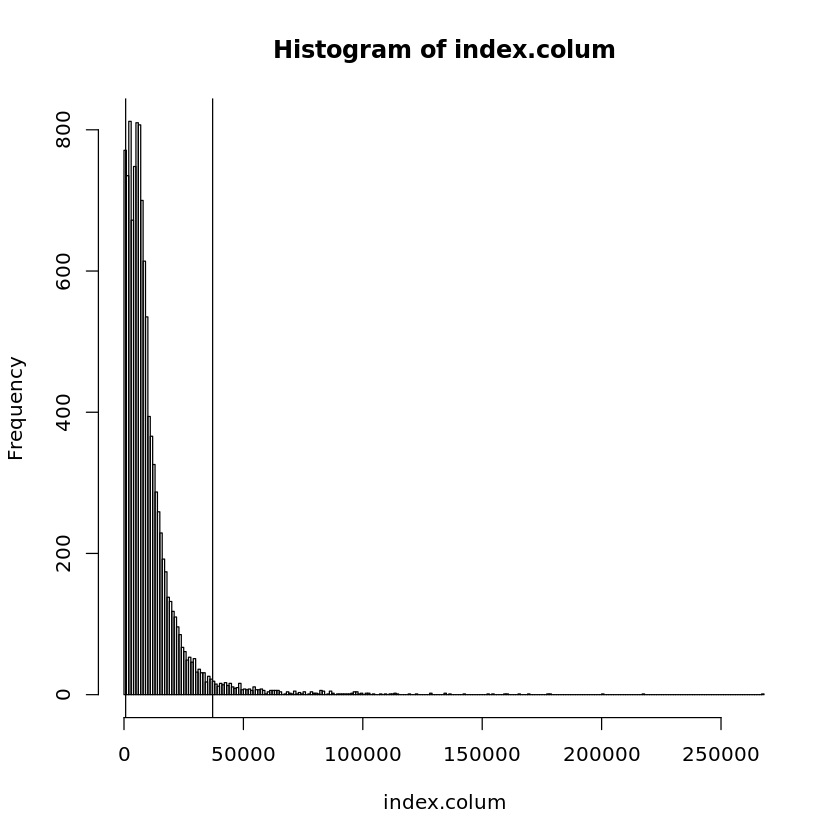

In [104]:
hist(index.colum,300)
abline(v=lower)
abline(v=upper)

Saving 6.67 x 6.67 in image



character(0)

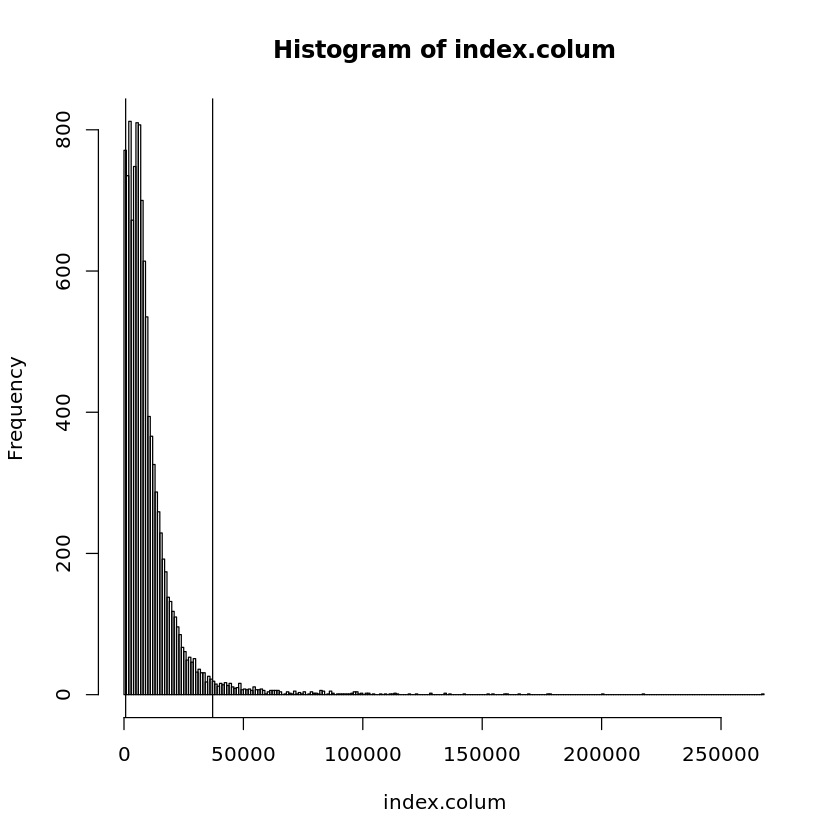

In [105]:
hist(index.colum,300)
abline(v=lower)
abline(v=upper)
ggsave("histogram_reads_per_cell.pdf")
system(paste0("gsutil cp histogram_reads_per_cell.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)

In [106]:
dim(all.data) #8,784 cells


[1] 32717 11010

In [107]:
# Filter based on number of UMI reads per cell across all genes
all.data.filt <- all.data[,which(index.colum>lower & index.colum<upper)]
all.data.filt[is.na(all.data.filt)] <- 0
dim(all.data.filt)

[1] 32717 10011

In [108]:
dim(all.data.filt)


[1] 32717 10011

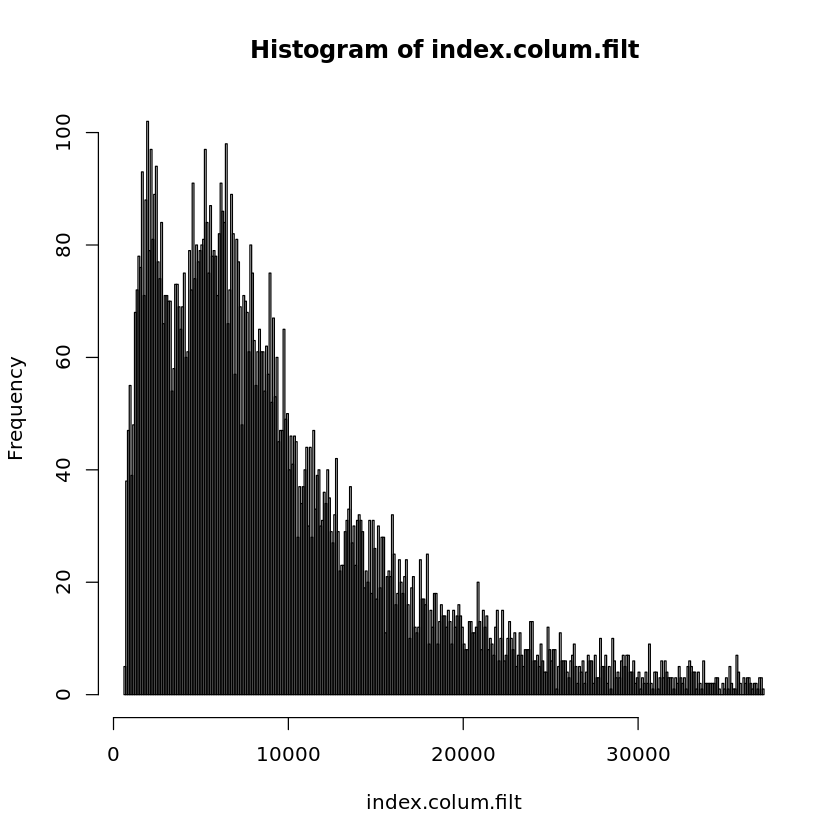

In [109]:
index.colum.filt = colSums(all.data.filt,na.rm=TRUE)
hist(index.colum.filt,300)


In [110]:
seurat.all.data <- CreateSeuratObject(counts = all.data.filt, project = "hBM_processing", min.cells = 10, 
                                      min.features = 300, names.delim = "-", names.field = 1)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [111]:
seurat.all.data

An object of class Seurat 
19019 features across 8747 samples within 1 assay 
Active assay: RNA (19019 features, 0 variable features)

In [112]:
saveRDS(seurat.all.data,file="seuratobj_alldata.rds")
system(paste0("gsutil cp seuratobj_alldata.rds gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)


character(0)

# Initial Clustering 

In [113]:
head(seurat.all.data@meta.data)

orig.ident     nCount_RNA nFeature_RNA
GCCTGGACTACT_BM16-C-R1-Exp1 hBM_processing 12480       311        
AAGATAAGGGCG_BM16-C-R1-Exp1 hBM_processing 33693      6844        
TAAATCGGTTAA_BM16-C-R1-Exp1 hBM_processing 37100      5717        
GTTGCCAACCAC_BM16-C-R1-Exp1 hBM_processing 36075      5835        
TAATGCTCTTGA_BM16-C-R1-Exp1 hBM_processing 31352      4892        
ACTAGTCCAGGG_BM16-C-R1-Exp1 hBM_processing 31564      6291

In [114]:
metadata_construction <- seurat.all.data@meta.data
head(metadata_construction)

orig.ident     nCount_RNA nFeature_RNA
GCCTGGACTACT_BM16-C-R1-Exp1 hBM_processing 12480       311        
AAGATAAGGGCG_BM16-C-R1-Exp1 hBM_processing 33693      6844        
TAAATCGGTTAA_BM16-C-R1-Exp1 hBM_processing 37100      5717        
GTTGCCAACCAC_BM16-C-R1-Exp1 hBM_processing 36075      5835        
TAATGCTCTTGA_BM16-C-R1-Exp1 hBM_processing 31352      4892        
ACTAGTCCAGGG_BM16-C-R1-Exp1 hBM_processing 31564      6291

In [ ]:
# 'BM16-C-R1-Exp1'
# 'BM16-E-R1-Exp2'
# 'BM16-F-R1-Exp1'
# 'BM16-F-R1-Exp2'
# 'BM16-F-R2-Exp1'
# 'BM16-O-R1-Exp1'
# 'BM16-S-R1-Exp2'
# 'BM17-C-R1-Exp1'
# 'BM17-F-R1-Exp1'
# 'BM17-F-R1-Exp2'
# 'BM17-F-R2-Exp1'
# 'BM17-O-R1-Exp1'


In [116]:
substr(row.names(metadata_construction)[1],14,nchar(row.names(metadata_construction)[1]))
substr(row.names(metadata_construction)[300],14,nchar(row.names(metadata_construction)[1]))
substr(row.names(metadata_construction)[600],14,nchar(row.names(metadata_construction)[1]))
substr(row.names(metadata_construction)[1000],14,nchar(row.names(metadata_construction)[1]))
substr(row.names(metadata_construction)[2000],14,nchar(row.names(metadata_construction)[1]))
substr(row.names(metadata_construction)[3000],14,nchar(row.names(metadata_construction)[1]))
substr(row.names(metadata_construction)[4000],14,nchar(row.names(metadata_construction)[1]))
substr(row.names(metadata_construction)[5000],14,nchar(row.names(metadata_construction)[1]))
substr(row.names(metadata_construction)[6000],14,nchar(row.names(metadata_construction)[1]))

[1] "BM16-C-R1-Exp1"

[1] "BM16-E-R1-Exp2"

[1] "BM16-E-R1-Exp2"

[1] "BM16-E-R1-Exp2"

[1] "BM16-F-R1-Exp1"

[1] "BM16-F-R1-Exp2"

[1] "BM16-O-R1-Exp1"

[1] "BM16-S-R1-Exp2"

[1] "BM17-F-R1-Exp2"

In [117]:
#function to extract array name (14 characters in)
extractname <- function(x) {substr(row.names(metadata_construction)[1:length(row.names(x))],14,
                                                 nchar(row.names(metadata_construction)[1:length(row.names(x))]))
                                            }

In [118]:
array_names <- extractname(metadata_construction)
length(array_names)

[1] 8747

In [119]:
metadata_construction$ArrayName <- array_names
head(metadata_construction)

orig.ident     nCount_RNA nFeature_RNA
GCCTGGACTACT_BM16-C-R1-Exp1 hBM_processing 12480       311        
AAGATAAGGGCG_BM16-C-R1-Exp1 hBM_processing 33693      6844        
TAAATCGGTTAA_BM16-C-R1-Exp1 hBM_processing 37100      5717        
GTTGCCAACCAC_BM16-C-R1-Exp1 hBM_processing 36075      5835        
TAATGCTCTTGA_BM16-C-R1-Exp1 hBM_processing 31352      4892        
ACTAGTCCAGGG_BM16-C-R1-Exp1 hBM_processing 31564      6291        
                            ArrayName     
GCCTGGACTACT_BM16-C-R1-Exp1 BM16-C-R1-Exp1
AAGATAAGGGCG_BM16-C-R1-Exp1 BM16-C-R1-Exp1
TAAATCGGTTAA_BM16-C-R1-Exp1 BM16-C-R1-Exp1
GTTGCCAACCAC_BM16-C-R1-Exp1 BM16-C-R1-Exp1
TAATGCTCTTGA_BM16-C-R1-Exp1 BM16-C-R1-Exp1
ACTAGTCCAGGG_BM16-C-R1-Exp1 BM16-C-R1-Exp1

In [120]:
metadata_construction$orig.ident = NULL
metadata_construction$nCount_RNA = NULL
metadata_construction$nFeature_RNA = NULL

In [126]:
substr(row.names(metadata_construction)[1000],14,17) #donor 
substr(row.names(metadata_construction)[1000],19,19) #processing
substr(row.names(metadata_construction)[1000],21,22) #replicate
substr(row.names(metadata_construction)[1000],24,27) #experiment

[1] "BM16"

[1] "E"

[1] "R1"

[1] "Exp2"

In [127]:
extractdonor <- function(x) {substr(row.names(metadata_construction)[1:length(row.names(x))],
                                  14,17)}

extractprocessing <- function(x) {substr(row.names(metadata_construction)[1:length(row.names(x))],
                                  19,19)}

extractreplicate <- function(x) {substr(row.names(metadata_construction)[1:length(row.names(x))],
                                  21,22)}

extractexp <- function(x) {substr(row.names(metadata_construction)[1:length(row.names(x))],
                                  24,27)}

In [128]:
donor <- extractdonor(metadata_construction)
length(donor)

processing <- extractprocessing(metadata_construction)
length(processing)

replicate <- extractreplicate(metadata_construction)
length(replicate)

experiment <- extractexp(metadata_construction)
length(experiment)


[1] 8747

[1] 8747

[1] 8747

[1] 8747

In [129]:
metadata_construction$Donor <- donor
metadata_construction$Processing <- processing
metadata_construction$Replicate <- replicate
metadata_construction$Experiment <- experiment


In [131]:
head(metadata_construction)
tail(metadata_construction)

ArrayName      Donor Processing Replicate
GCCTGGACTACT_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
AAGATAAGGGCG_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
TAAATCGGTTAA_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
GTTGCCAACCAC_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
TAATGCTCTTGA_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
ACTAGTCCAGGG_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
                            Experiment
GCCTGGACTACT_BM16-C-R1-Exp1 Exp1      
AAGATAAGGGCG_BM16-C-R1-Exp1 Exp1      
TAAATCGGTTAA_BM16-C-R1-Exp1 Exp1      
GTTGCCAACCAC_BM16-C-R1-Exp1 Exp1      
TAATGCTCTTGA_BM16-C-R1-Exp1 Exp1      
ACTAGTCCAGGG_BM16-C-R1-Exp1 Exp1

ArrayName      Donor Processing Replicate
TGGGGTCTGAGG_BM17-O-R1-Exp1 BM17-O-R1-Exp1 BM17  O          R1       
TAAGGCGACGAC_BM17-O-R1-Exp1 BM17-O-R1-Exp1 BM17  O          R1       
TTCTCAGTCGAG_BM17-O-R1-Exp1 BM17-O-R1-Exp1 BM17  O          R1       
TGGTCCAAGATA_BM17-O-R1-Exp1 BM17-O-R1-Exp1 BM17  O          R1       
CTGAGTCTTGTG_BM17-O-R1-Exp1 BM17-O-R1-Exp1 BM17  O          R1       
AAATTGGCCCAG_BM17-O-R1-Exp1 BM17-O-R1-Exp1 BM17  O          R1       
                            Experiment
TGGGGTCTGAGG_BM17-O-R1-Exp1 Exp1      
TAAGGCGACGAC_BM17-O-R1-Exp1 Exp1      
TTCTCAGTCGAG_BM17-O-R1-Exp1 Exp1      
TGGTCCAAGATA_BM17-O-R1-Exp1 Exp1      
CTGAGTCTTGTG_BM17-O-R1-Exp1 Exp1      
AAATTGGCCCAG_BM17-O-R1-Exp1 Exp1

In [132]:
seurat.all.data <- AddMetaData(seurat.all.data, metadata_construction)
 <- AddMetaData(seurat.all.data, metadata_construction)


In [135]:
seurat.all.data[["percent.mt"]] <- PercentageFeatureSet(seurat.all.data, pattern = "^MT-")

In [136]:
head(seurat.all.data@meta.data)

orig.ident     nCount_RNA nFeature_RNA
GCCTGGACTACT_BM16-C-R1-Exp1 hBM_processing 12480       311        
AAGATAAGGGCG_BM16-C-R1-Exp1 hBM_processing 33693      6844        
TAAATCGGTTAA_BM16-C-R1-Exp1 hBM_processing 37100      5717        
GTTGCCAACCAC_BM16-C-R1-Exp1 hBM_processing 36075      5835        
TAATGCTCTTGA_BM16-C-R1-Exp1 hBM_processing 31352      4892        
ACTAGTCCAGGG_BM16-C-R1-Exp1 hBM_processing 31564      6291        
                            ArrayName      Donor Processing Replicate
GCCTGGACTACT_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
AAGATAAGGGCG_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
TAAATCGGTTAA_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
GTTGCCAACCAC_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
TAATGCTCTTGA_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
ACTAGTCCAGGG_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
                            Experiment percent.mt
GCCTGGACTACT_BM16-C-R1-Exp1 Exp1       94.342949 
AAGATAAGGGCG_BM16-C-R1-Exp1 Exp1        2.751313 
TAAATCGGTTAA_BM16-C-R1-Exp1 Exp1        3.541779 
GTTGCCAACCAC_BM16-C-R1-Exp1 Exp1        1.948718 
TAATGCTCTTGA_BM16-C-R1-Exp1 Exp1        7.476397 
ACTAGTCCAGGG_BM16-C-R1-Exp1 Exp1        5.170447

In [137]:
saveRDS(seurat.all.data,file="seuratobj_alldata.rds")
system(paste0("gsutil cp seuratobj_alldata.rds gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)


character(0)

# Initial pass and cell type IDs

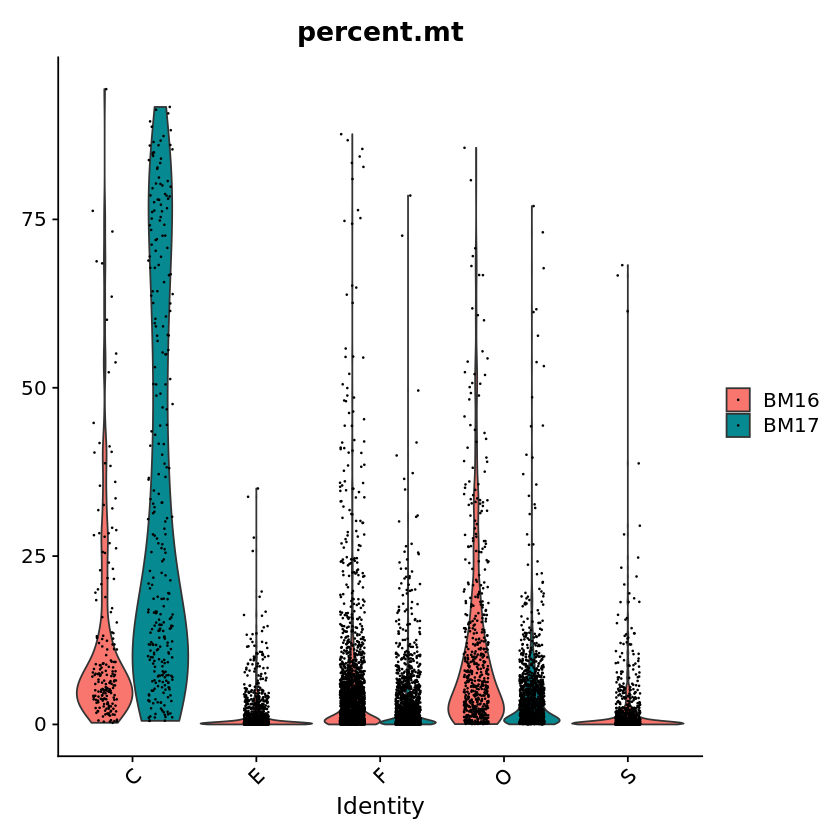

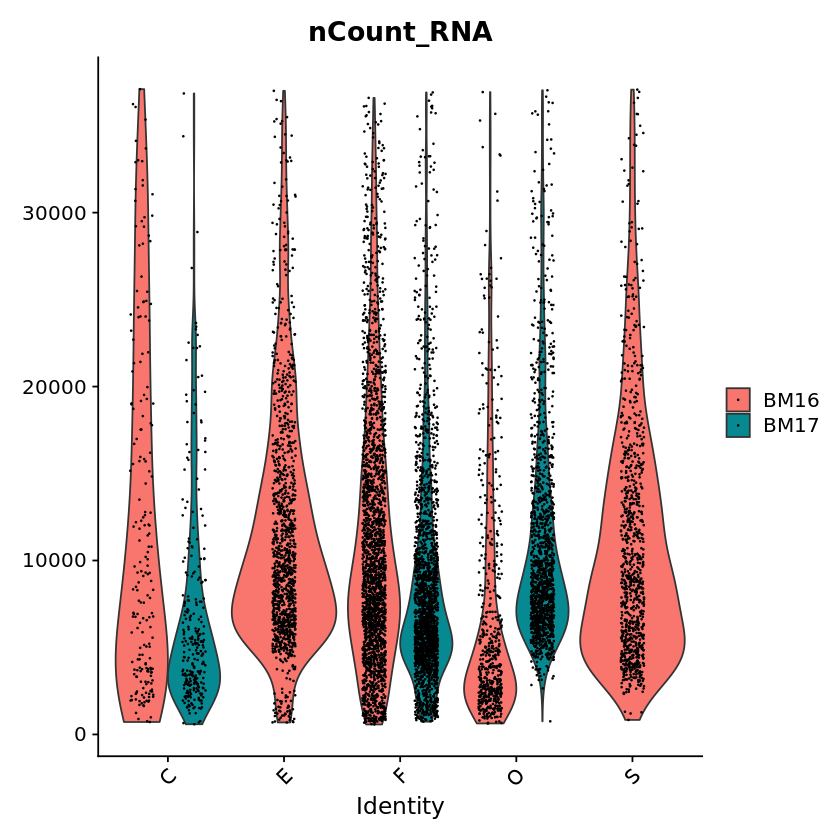

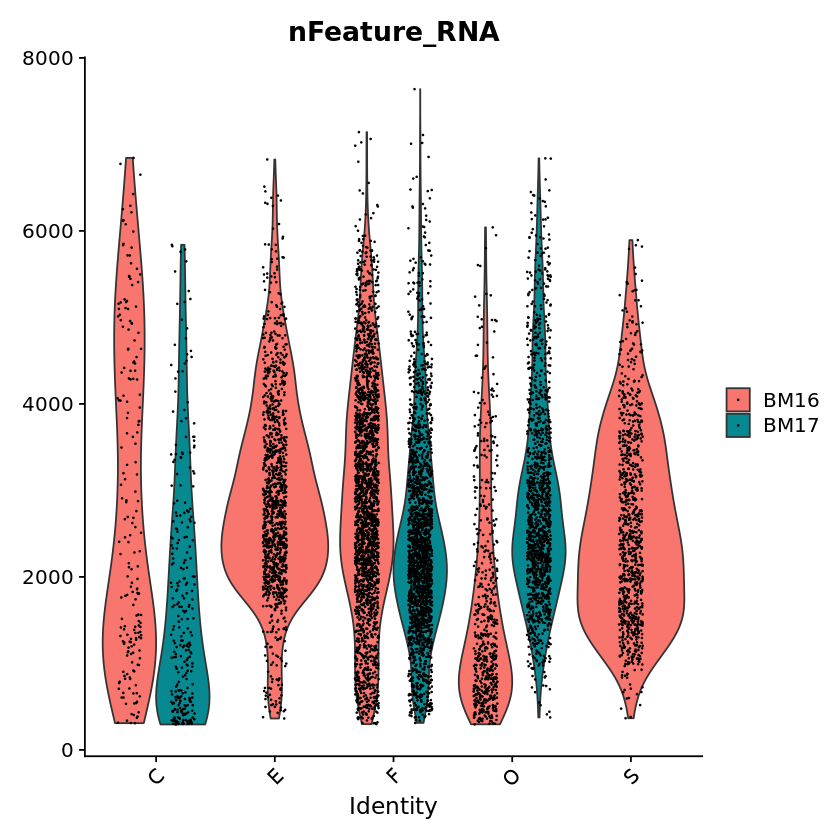

In [140]:
Idents(object=seurat.all.data) <- "Processing"
VlnPlot(seurat.all.data, features = c("percent.mt"), pt.size = 0.1, split.by = 'Donor')
VlnPlot(seurat.all.data, features = c("nCount_RNA"), pt.size = 0.1, split.by = 'Donor')
VlnPlot(seurat.all.data, features = c("nFeature_RNA"), pt.size = 0.1, split.by = 'Donor')

In [141]:
install.packages("gridExtra")

Installing package into ‘/home/jupyter-user/.rpackages’
(as ‘lib’ is unspecified)



In [142]:
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [143]:
library(cowplot)

In [232]:
# colors
cols.donor <- c("#5B1A18","#D67236")
cols.processing <- brewer.pal(5,"Dark2")

In [229]:
Idents(object=seurat.all.data) <- "Processing"
vlnMT <- VlnPlot(seurat.all.data, features = c("percent.mt"), pt.size = 0, split.by = 'Donor', cols = cols.donor)
vlncount <- VlnPlot(seurat.all.data, features = c("nCount_RNA"), pt.size = 0, split.by = 'Donor', cols = cols.donor)
vlnfeat <- VlnPlot(seurat.all.data, features = c("nFeature_RNA"), pt.size = 0, split.by = 'Donor', cols = cols.donor)

character(0)

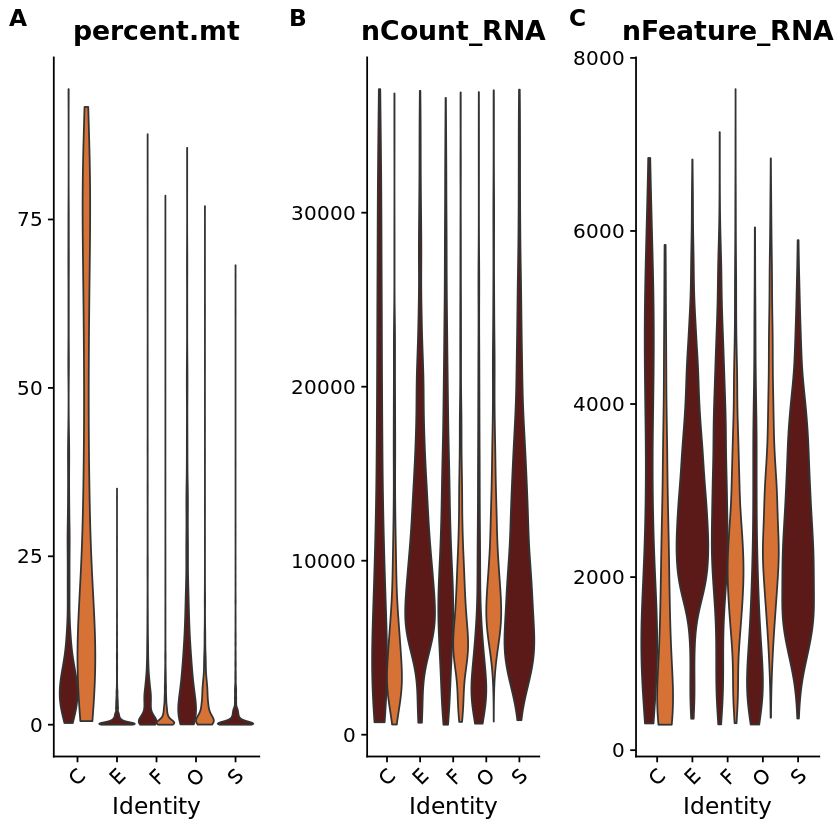

In [230]:
plot_grid(vlnMT + NoLegend(),vlncount+ NoLegend(), vlnfeat + NoLegend(), labels = c('A', 'B', 'C'), label_size = 14, nrow=1)
ggsave("tech_violin.pdf", useDingbats = F, height = 4, width = 8, units = "in")
system(paste0("gsutil cp tech_violin.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen"), intern=TRUE)

In [146]:
help(plot_grid)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
When using repel, set xnudge and ynudge to 0 for optimal results

Centering and scaling data matrix

PC_ 1 
Positive:  CLU, KRT19, TCN1, ALDH1A3, TACSTD2, KRT7, CRABP2, TNFRSF11B, PERP, THRSP 
	   ACACB, TNFSF10, PRSS8, ARHGEF26, SFRP1, S100A9, AK5, PTHLH, S100A16, LAMA3 
	   CDH1, SLC30A2, KRT8, STAC2, ERBB3, MYO5B, RAI14, DSG2, STEAP4, COCH 
Negative:  LAPTM5, TYROBP, ITGB2, CD68, IFI30, FCER1G, CTSL, ZEB2, CTSD, PLA2G7 
	   TIMP2, LRP1, NCF2, CD53, APOE, MS4A7, CYP27A1, KCTD12, SRGN, MSR1 
	   EMILIN2, CECR1, MS4A4A, GM2A, FGR, CYBB, FCGRT, PIK3AP1, APOC1, LAIR1 
PC_ 2 
Positive:  IFRD1, TNFRSF12A, KLF6, ELF3, CDKN1A, MAFF, ATF3, CLDN4, ITGA2, MAP2 
	   HSPB1, JUN, DDIT3, HSPA1B, PVRL4, TINAGL1, BAG3, MT2A, PLK2, MACF1 
	   IER2, MIDN, GRB7, GPRC5A, BBC3, JMJD1C, GADD45A, SLC3A2, DUSP8, CLDN12 
Negative:  

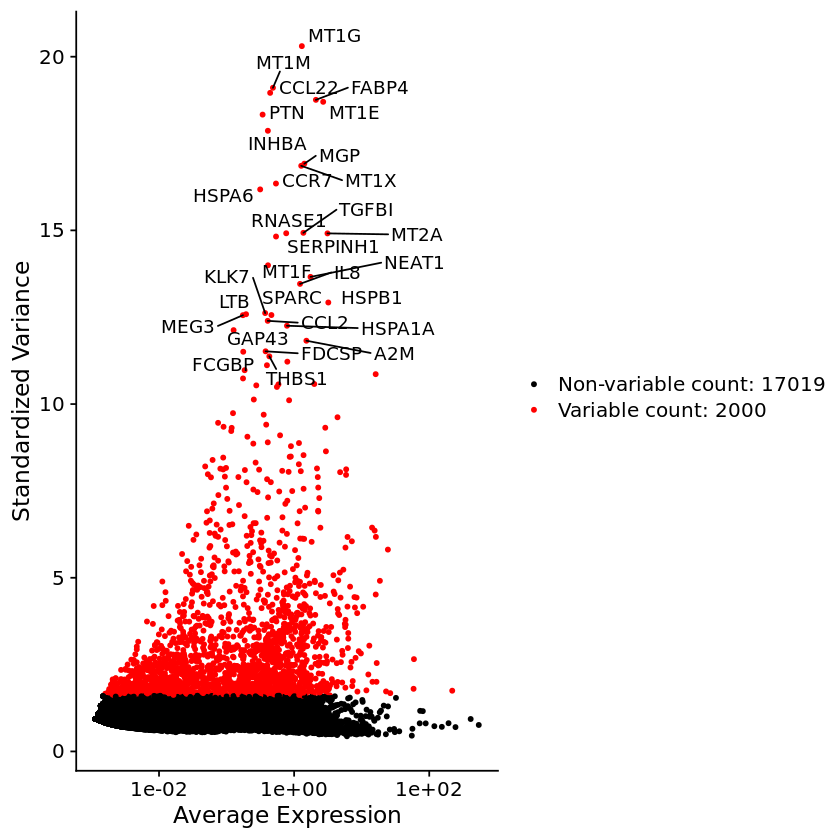

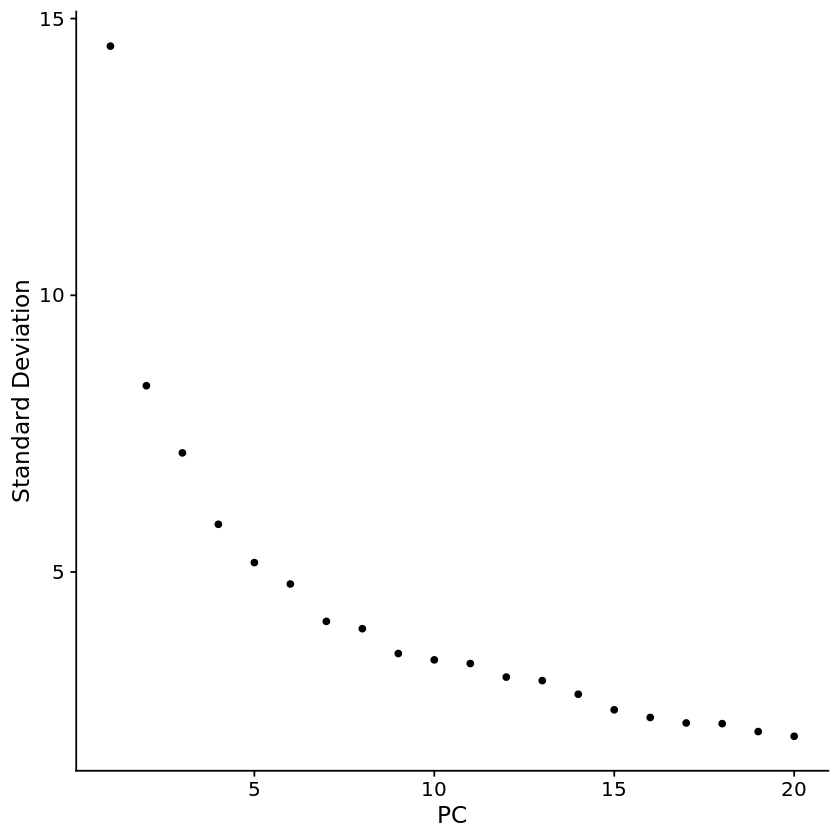

In [154]:
# normalize and initial clustering 
seurat.all.data <- NormalizeData(seurat.all.data, normalization.method = "LogNormalize", scale.factor = 10000)
seurat.all.data <- FindVariableFeatures(seurat.all.data, selection.method = "vst", nfeatures = 2000)

# Identify the 30 most highly variable genes
top_merge <- head(VariableFeatures(seurat.all.data), 30)

# plot variable features with and without labels
plotmerge1 <- VariableFeaturePlot(seurat.all.data)
plotmerge2 <- LabelPoints(plot = plotmerge1, points = top_merge, repel = TRUE)
plotmerge2

# scale and PCA, can regress stuff out here too (do not regress for now)
seurat.all.data <- ScaleData(seurat.all.data, features = rownames(seurat.all.data))
seurat.all.data <- RunPCA(seurat.all.data, features = VariableFeatures(object = seurat.all.data))

ElbowPlot(seurat.all.data)


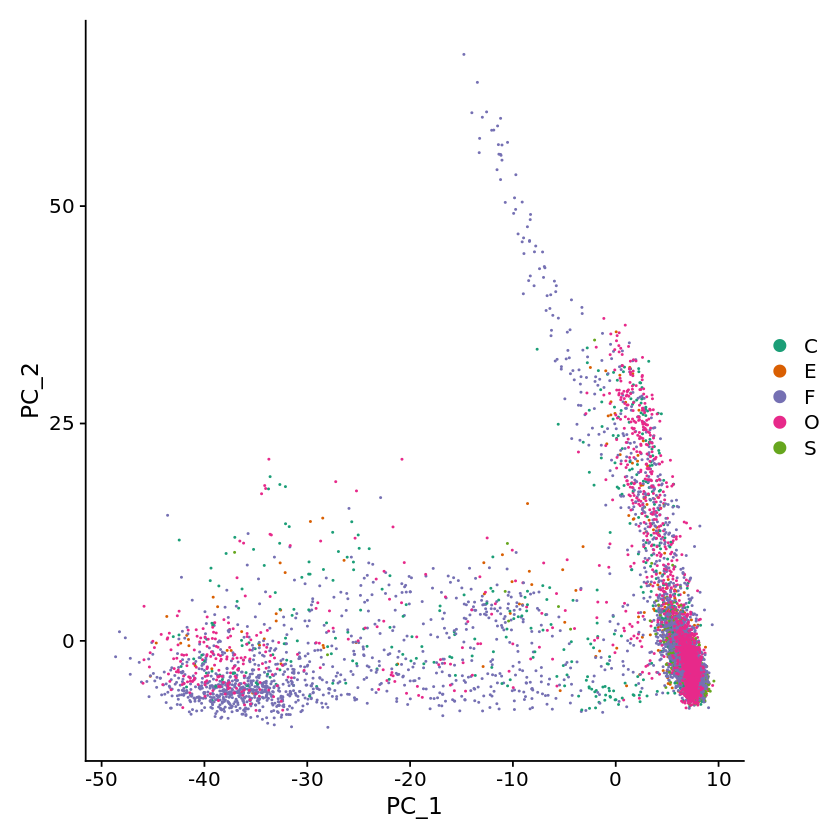

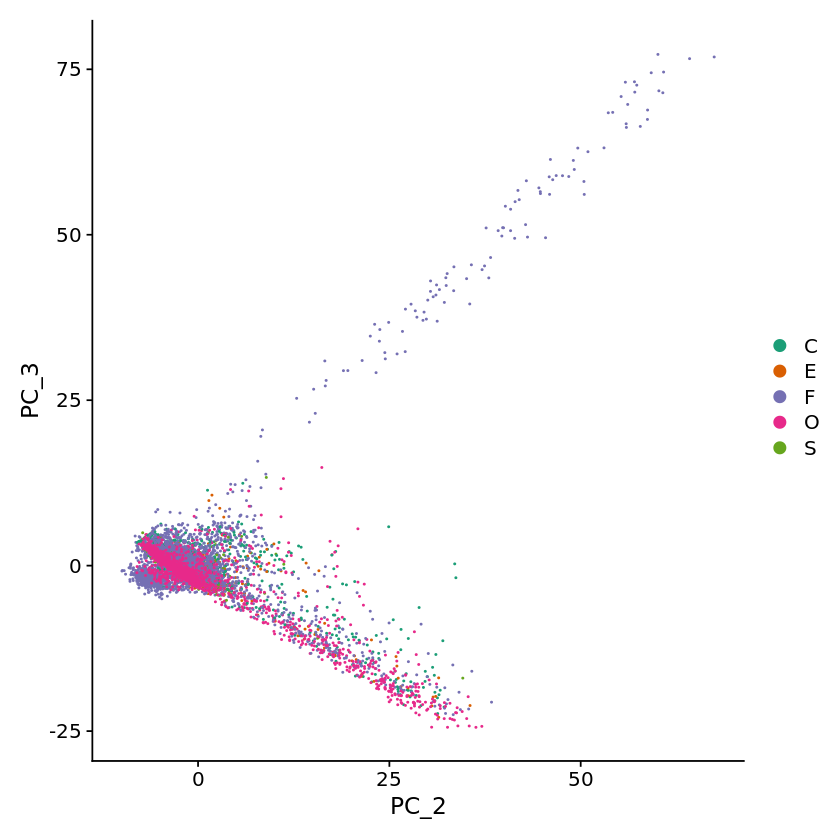

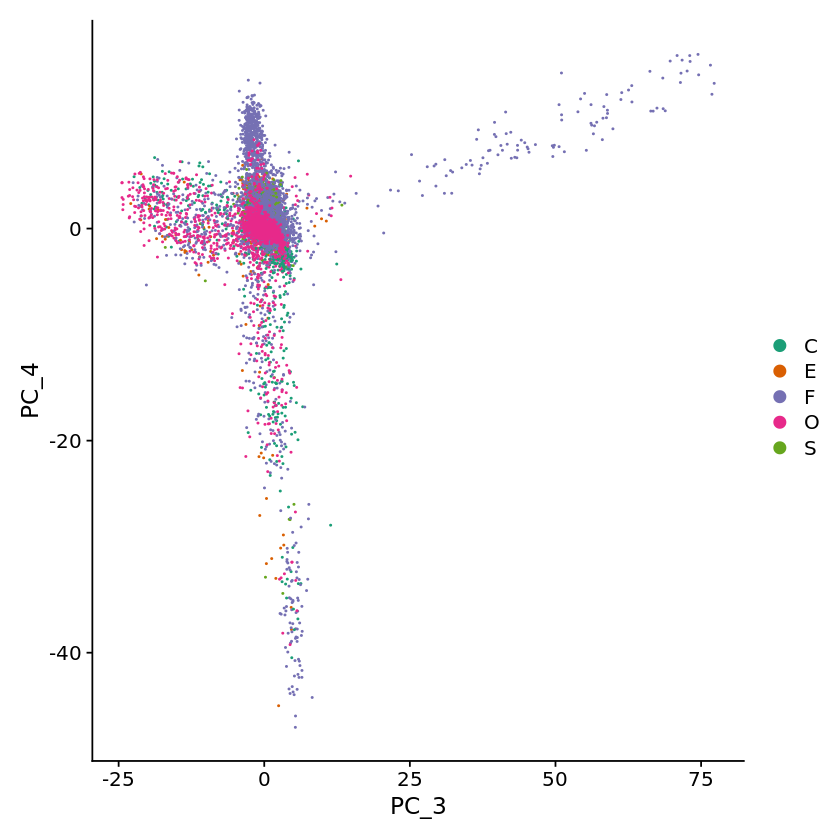

In [233]:
Idents(object=seurat.all.data) <- "Processing"
DimPlot(seurat.all.data, reduction = "pca", dims = c(1,2), cols = cols.processing)
DimPlot(seurat.all.data, reduction = "pca", dims = c(2,3), cols = cols.processing)
DimPlot(seurat.all.data, reduction = "pca", dims = c(3,4), cols = cols.processing)

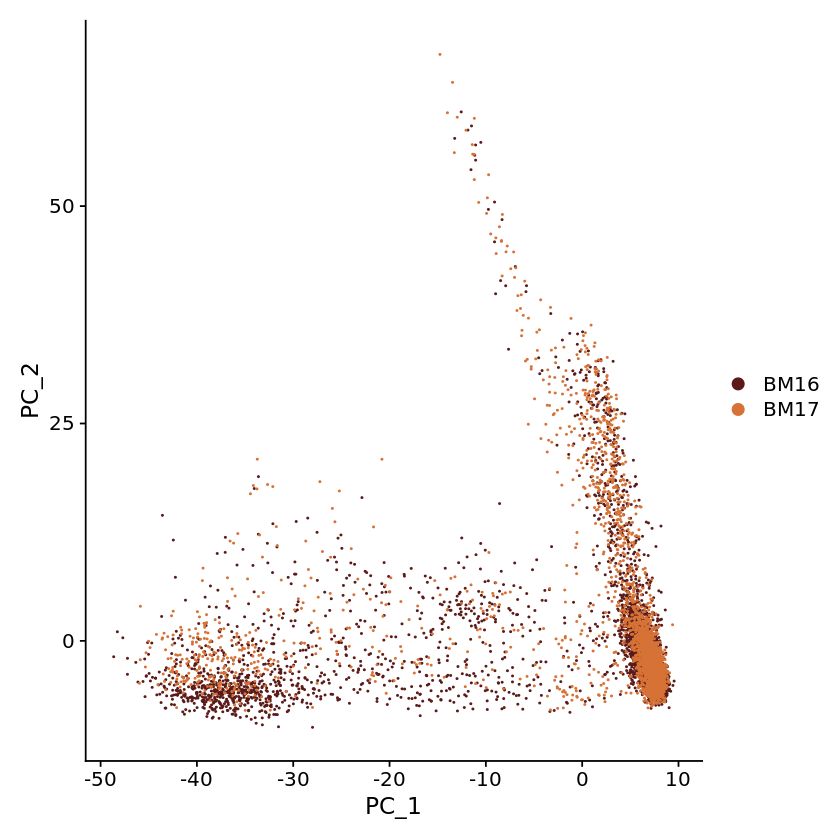

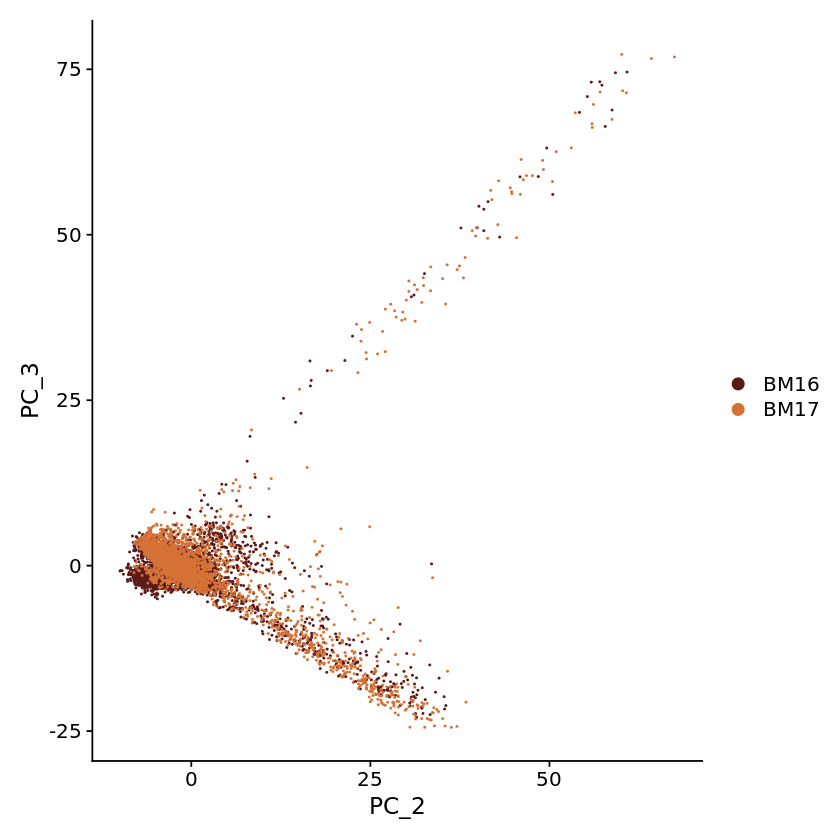

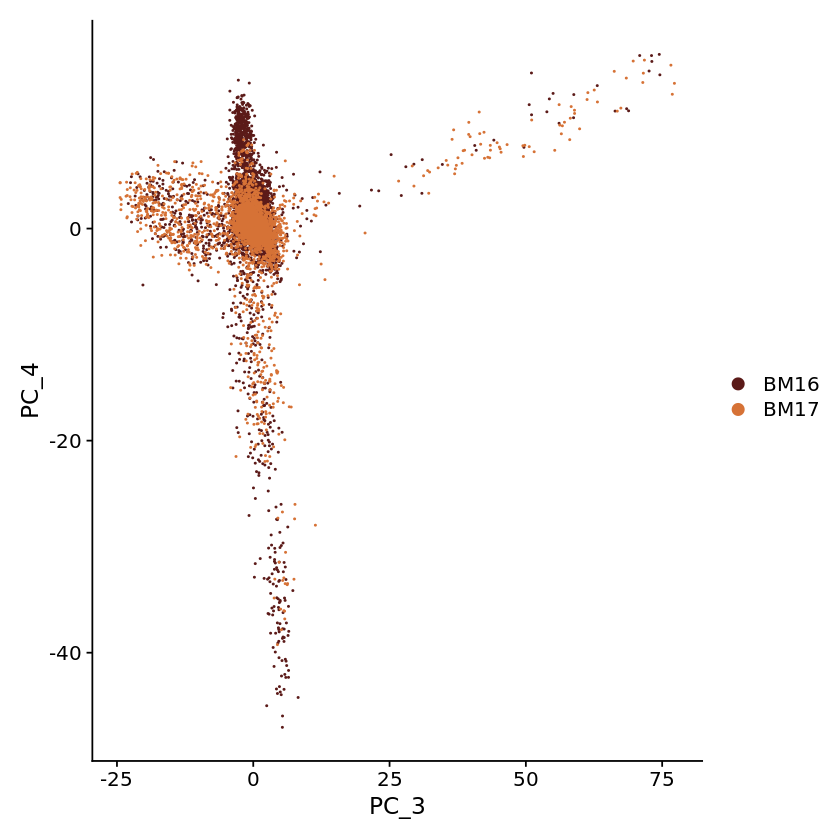

In [234]:
Idents(object=seurat.all.data) <- "Donor"
DimPlot(seurat.all.data, reduction = "pca", dims = c(1,2), cols = cols.donor)
DimPlot(seurat.all.data, reduction = "pca", dims = c(2,3),cols = cols.donor)
DimPlot(seurat.all.data, reduction = "pca", dims = c(3,4),cols = cols.donor)

In [236]:
Idents(object=seurat.all.data) <- "Processing"
pca.1P <- DimPlot(seurat.all.data, reduction = "pca", dims = c(1,2), cols = cols.processing)
pca.2P <- DimPlot(seurat.all.data, reduction = "pca", dims = c(3,4), cols = cols.processing)
pca.3P <- DimPlot(seurat.all.data, reduction = "pca", dims = c(5,6), cols = cols.processing)

Idents(object=seurat.all.data) <- "Donor"
pca.1D <- DimPlot(seurat.all.data, reduction = "pca", dims = c(1,2), cols = cols.donor)
pca.2D <- DimPlot(seurat.all.data, reduction = "pca", dims = c(3,4), cols = cols.donor)
pca.3D <- DimPlot(seurat.all.data, reduction = "pca", dims = c(5,6), cols = cols.donor)

In [158]:
seurat.all.data <- RunTSNE(seurat.all.data, reduction = "pca", dims = 1:20)
seurat.all.data <- RunUMAP(seurat.all.data, reduction = "pca", dims = 1:20)
seurat.all.data <- FindNeighbors(seurat.all.data, reduction = "pca", dims = 1:20)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
18:15:57 UMAP embedding parameters a = 0.9922 b = 1.112

18:15:57 Read 8747 rows and found 20 numeric columns

18:15:57 Using Annoy for neighbor search, n_neighbors = 30

18:15:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:15:58 Writing NN index file to temp file /tmp/RtmpcPkNxC/file2d2c59371b

18:15:58 Searching Annoy index using 1 thread, search_k = 3000

18:16:02 Annoy recall = 100%

18:16:02 Commencing smooth kNN distance calibration using 1 thread

18:16:03 Initializing from 

character(0)

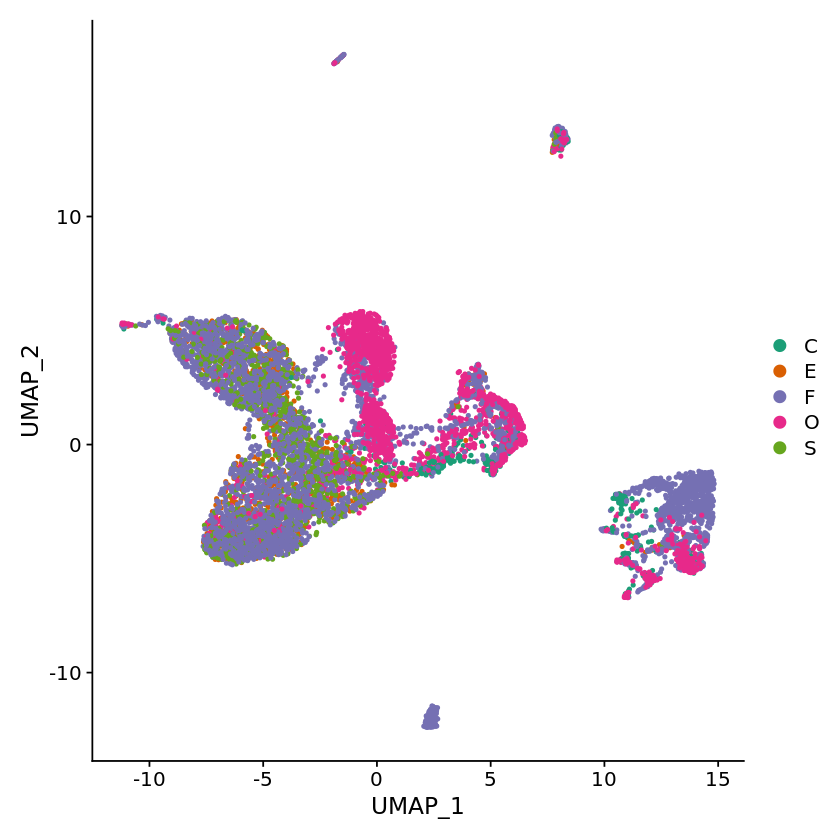

character(0)

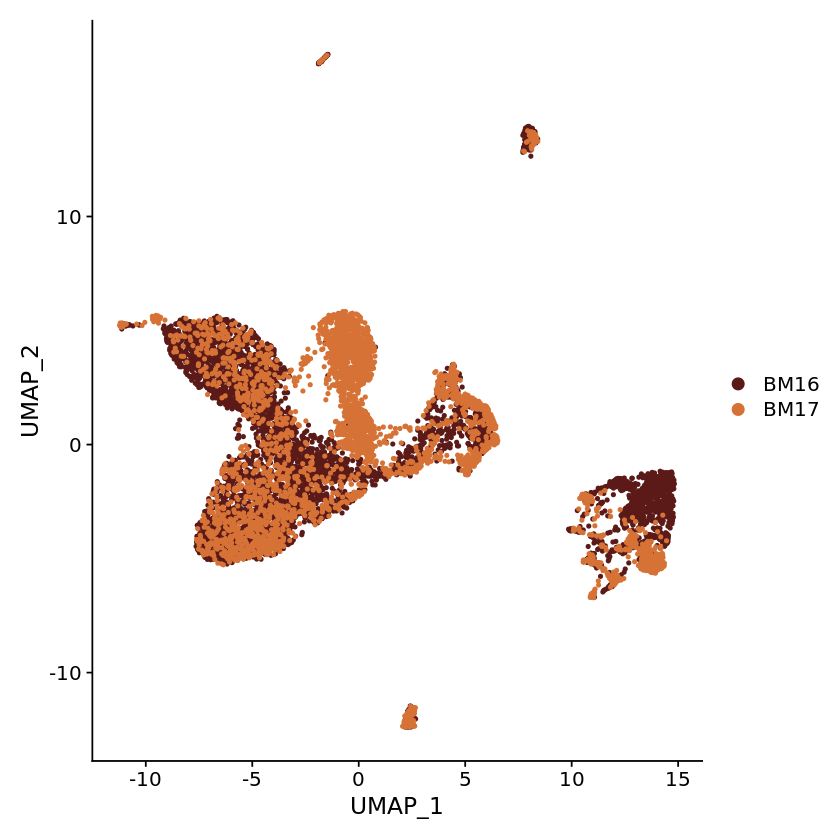

In [237]:
DimPlot(seurat.all.data, reduction = "umap", group.by = "Processing", pt.size = 0.8, cols = cols.processing)
ggsave("UMAP_Processing.pdf", useDingbats = F, height = 8, width = 8, units = "in")
system(paste0("gsutil cp UMAP_Processing.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)

DimPlot(seurat.all.data, reduction = "umap", group.by = "Donor", pt.size = 0.8, cols = cols.donor)
ggsave("UMAP_Donor.pdf", useDingbats = F, height = 8, width = 8, units = "in")
system(paste0("gsutil cp UMAP_Donor.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)

In [201]:
seurat.all.data <- FindClusters(seurat.all.data, resolution = 0.2)


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8747
Number of edges: 305659

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9410
Number of communities: 11
Elapsed time: 1 seconds


In [202]:
head(seurat.all.data@meta.data)
unique(seurat.all.data@meta.data$seurat_clusters)

orig.ident     nCount_RNA nFeature_RNA
GCCTGGACTACT_BM16-C-R1-Exp1 hBM_processing 12480       311        
AAGATAAGGGCG_BM16-C-R1-Exp1 hBM_processing 33693      6844        
TAAATCGGTTAA_BM16-C-R1-Exp1 hBM_processing 37100      5717        
GTTGCCAACCAC_BM16-C-R1-Exp1 hBM_processing 36075      5835        
TAATGCTCTTGA_BM16-C-R1-Exp1 hBM_processing 31352      4892        
ACTAGTCCAGGG_BM16-C-R1-Exp1 hBM_processing 31564      6291        
                            ArrayName      Donor Processing Replicate
GCCTGGACTACT_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
AAGATAAGGGCG_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
TAAATCGGTTAA_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
GTTGCCAACCAC_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
TAATGCTCTTGA_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
ACTAGTCCAGGG_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
                            Experiment percent.mt RNA_snn_res.0.4
GCCTGGACTACT_BM16-C-R1-Exp1 Exp1       94.342949  7              
AAGATAAGGGCG_BM16-C-R1-Exp1 Exp1        2.751313  3              
TAAATCGGTTAA_BM16-C-R1-Exp1 Exp1        3.541779  3              
GTTGCCAACCAC_BM16-C-R1-Exp1 Exp1        1.948718  3              
TAATGCTCTTGA_BM16-C-R1-Exp1 Exp1        7.476397  9              
ACTAGTCCAGGG_BM16-C-R1-Exp1 Exp1        5.170447  3              
                            seurat_clusters RNA_snn_res.0.5 RNA_snn_res.0.6
GCCTGGACTACT_BM16-C-R1-Exp1 5               7               8              
AAGATAAGGGCG_BM16-C-R1-Exp1 2               3               3              
TAAATCGGTTAA_BM16-C-R1-Exp1 2               3               3              
GTTGCCAACCAC_BM16-C-R1-Exp1 2               3               3              
TAATGCTCTTGA_BM16-C-R1-Exp1 3               10              10             
ACTAGTCCAGGG_BM16-C-R1-Exp1 2               3               3              
                            RNA_snn_res.0.3 RNA_snn_res.0.2
GCCTGGACTACT_BM16-C-R1-Exp1 3               5              
AAGATAAGGGCG_BM16-C-R1-Exp1 3               2              
TAAATCGGTTAA_BM16-C-R1-Exp1 3               2              
GTTGCCAACCAC_BM16-C-R1-Exp1 3               2              
TAATGCTCTTGA_BM16-C-R1-Exp1 8               3              
ACTAGTCCAGGG_BM16-C-R1-Exp1 3               2

[1] 5  2  3  6  0  1  7  10 4  9  8 
Levels: 0 1 2 3 4 5 6 7 8 9 10

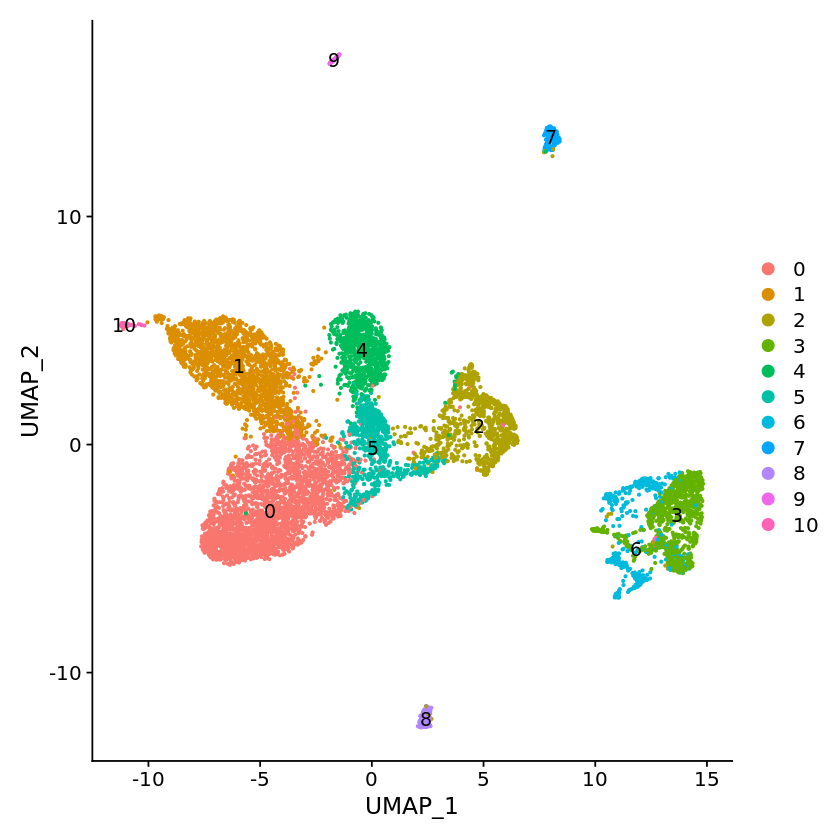

In [203]:
DimPlot(seurat.all.data, reduction = "umap", label = TRUE, pt.size = 0.5)  


In [204]:
Idents(object=seurat.all.data) <- "RNA_snn_res.0.2"
seurat.all.data.markers <- FindAllMarkers(seurat.all.data, test.use = "wilcox", 
                                          only.pos = TRUE, min.pct =0.2, logfc.threshold = 0.5)

write.table(seurat.all.data.markers,file="seurat.all.markers.wilcox.res02.txt",sep="\t",quote=FALSE,col.names=NA)
system(paste0("gsutil cp seurat.all.markers.wilcox.res02.txt gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



character(0)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Saving 6.67 x 6.67 in image



character(0)

Finished averaging RNA for cluster 0

Finished averaging RNA for cluster 1

Finished averaging RNA for cluster 2

Finished averaging RNA for cluster 3

Finished averaging RNA for cluster 4

Finished averaging RNA for cluster 5

Finished averaging RNA for cluster 6

Finished averaging RNA for cluster 7

Finished averaging RNA for cluster 8

Finished averaging RNA for cluster 9

Finished averaging RNA for cluster 10

Centering and scaling data matrix

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



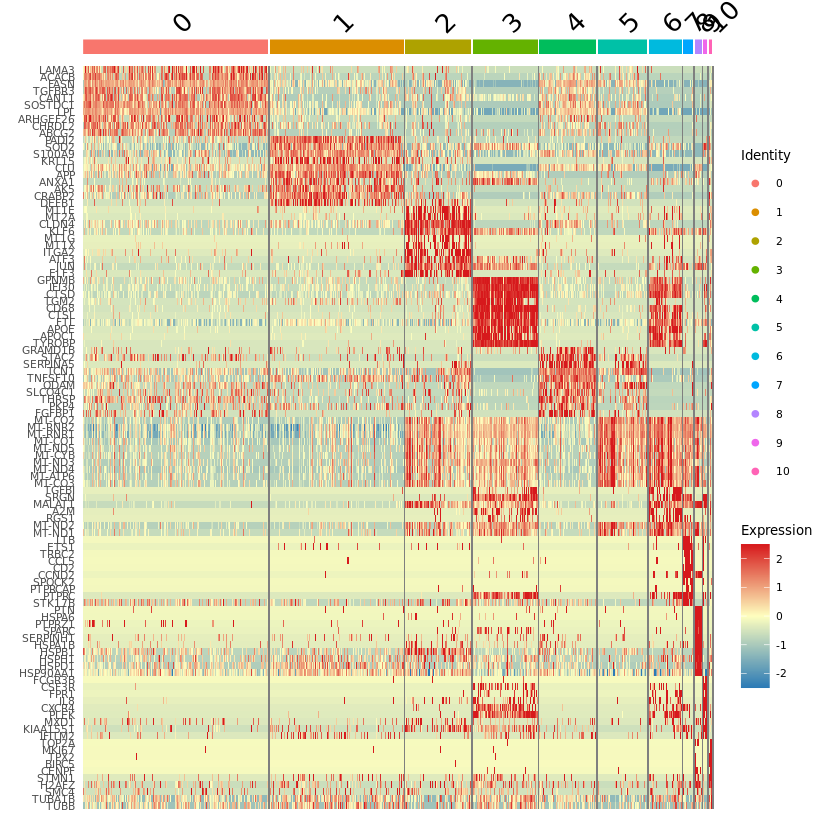

Saving 6.67 x 6.67 in image



character(0)

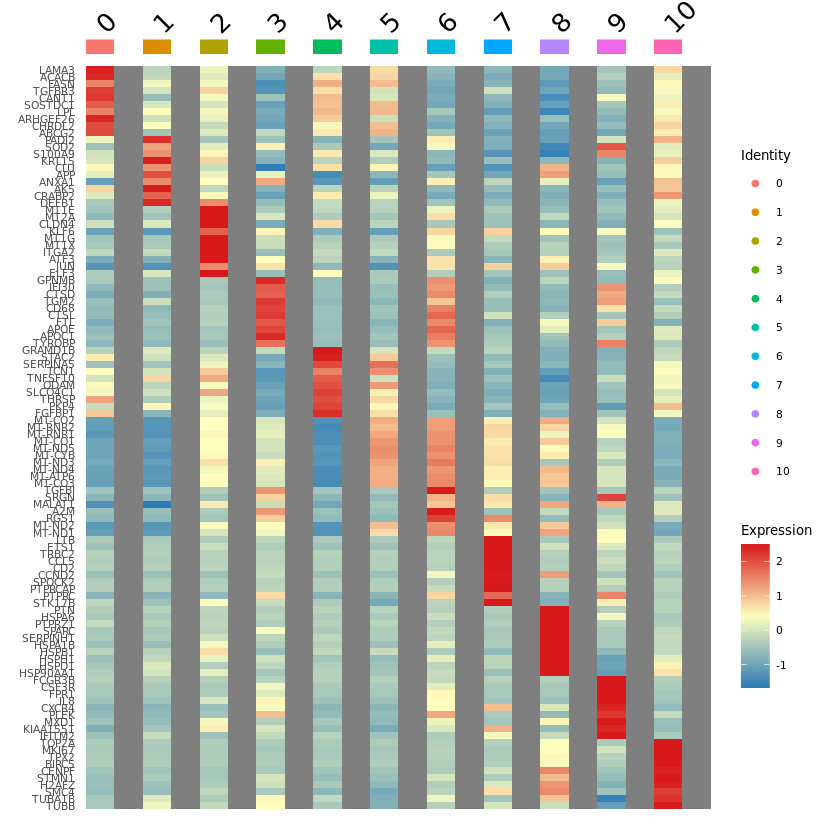

In [205]:
top10 <- seurat.all.data.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(seurat.all.data,features=top10$gene, raster = FALSE) + theme(text = element_text(size = 8)) + scale_fill_gradientn(colors = colorRampPalette(c("#2c7bb6", "#ffffbf", "#d7191c"))(256))
ggsave("Exp_Heatmap_res02_BluYR.pdf", useDingbats = F)
system(paste0("gsutil cp Exp_Heatmap_res02_BluYR.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)

seurat.all.data.averages <- AverageExpression(seurat.all.data, return.seurat = TRUE)
DoHeatmap(seurat.all.data.averages,features=top10$gene, raster = FALSE) + theme(text = element_text(size = 8)) + scale_fill_gradientn(colors = colorRampPalette(c("#2c7bb6", "#ffffbf", "#d7191c"))(256))
ggsave("Exp_Heatmap_Avg_res02_BluYR.pdf", useDingbats = F)
system(paste0("gsutil cp Exp_Heatmap_Avg_res02_BluYR.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)

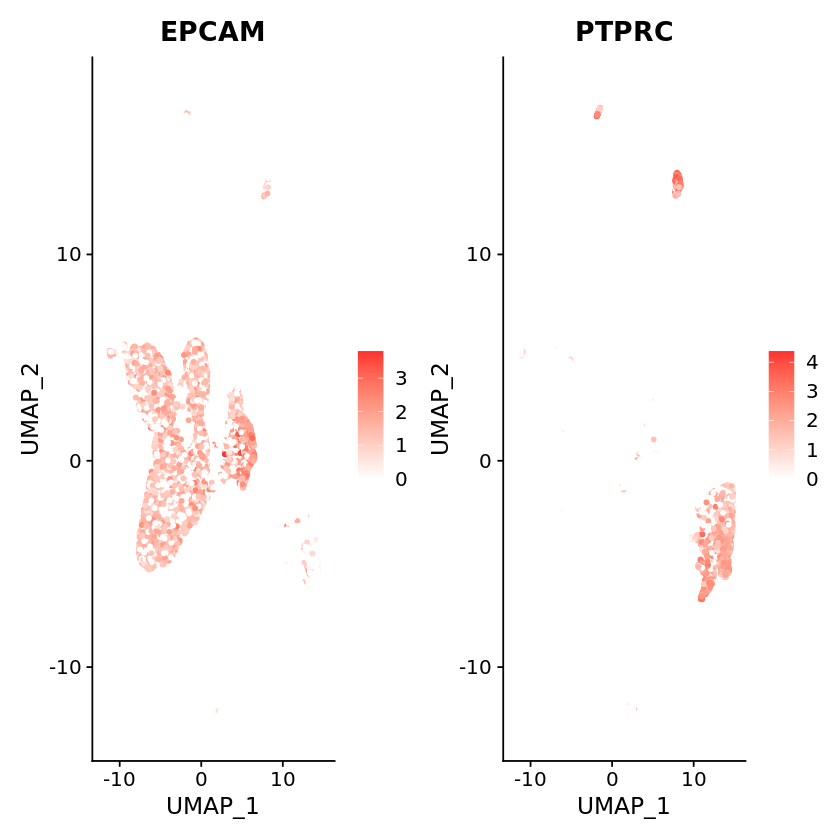

In [207]:
FeaturePlot(seurat.all.data, features = c("EPCAM","PTPRC"), pt.size = 1, cols = c("gray100","firebrick1"), reduction = "umap")




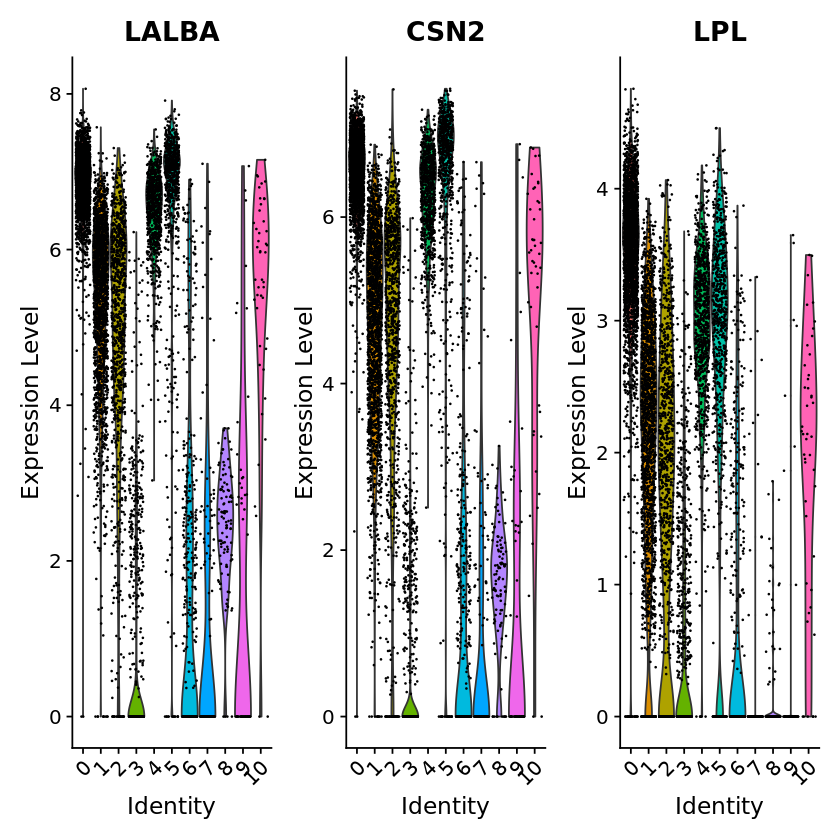

In [211]:
VlnPlot(seurat.all.data, features = c("LALBA","CSN2","LPL"), pt.size = 0.1)

In [212]:
Idents(object=seurat.all.data) <- "RNA_snn_res.0.2"
seurat.all.data <- RenameIdents(seurat.all.data, 
`0` = "luminal lactocyte 1", 
`1` = "luminal 2", 
`2` = "luminal 2 MThigh", 
`3` = "macrophages", 
`4` = "luminal lactocycte 2", 
`5` = "luminal lactocycte 3",
`6` = "milk macrophage", 
`7` = "T cells", 
`8` = "fibroblasts", 
`9` = "neutrophils", 
`10` = "luminal 2 proliferating")

In [213]:
seurat.all.data <- StashIdent(object = seurat.all.data, save.name = 'cell_IDs')


With Seurat 3.X, stashing identity classes can be accomplished with the following:
seurat.all.data[["cell_IDs"]] <- Idents(object = seurat.all.data)



In [214]:
head(seurat.all.data@meta.data)

orig.ident     nCount_RNA nFeature_RNA
GCCTGGACTACT_BM16-C-R1-Exp1 hBM_processing 12480       311        
AAGATAAGGGCG_BM16-C-R1-Exp1 hBM_processing 33693      6844        
TAAATCGGTTAA_BM16-C-R1-Exp1 hBM_processing 37100      5717        
GTTGCCAACCAC_BM16-C-R1-Exp1 hBM_processing 36075      5835        
TAATGCTCTTGA_BM16-C-R1-Exp1 hBM_processing 31352      4892        
ACTAGTCCAGGG_BM16-C-R1-Exp1 hBM_processing 31564      6291        
                            ArrayName      Donor Processing Replicate
GCCTGGACTACT_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
AAGATAAGGGCG_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
TAAATCGGTTAA_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
GTTGCCAACCAC_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
TAATGCTCTTGA_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
ACTAGTCCAGGG_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
                            Experiment percent.mt RNA_snn_res.0.4
GCCTGGACTACT_BM16-C-R1-Exp1 Exp1       94.342949  7              
AAGATAAGGGCG_BM16-C-R1-Exp1 Exp1        2.751313  3              
TAAATCGGTTAA_BM16-C-R1-Exp1 Exp1        3.541779  3              
GTTGCCAACCAC_BM16-C-R1-Exp1 Exp1        1.948718  3              
TAATGCTCTTGA_BM16-C-R1-Exp1 Exp1        7.476397  9              
ACTAGTCCAGGG_BM16-C-R1-Exp1 Exp1        5.170447  3              
                            seurat_clusters RNA_snn_res.0.5 RNA_snn_res.0.6
GCCTGGACTACT_BM16-C-R1-Exp1 5               7               8              
AAGATAAGGGCG_BM16-C-R1-Exp1 2               3               3              
TAAATCGGTTAA_BM16-C-R1-Exp1 2               3               3              
GTTGCCAACCAC_BM16-C-R1-Exp1 2               3               3              
TAATGCTCTTGA_BM16-C-R1-Exp1 3               10              10             
ACTAGTCCAGGG_BM16-C-R1-Exp1 2               3               3              
                            RNA_snn_res.0.3 RNA_snn_res.0.2
GCCTGGACTACT_BM16-C-R1-Exp1 3               5              
AAGATAAGGGCG_BM16-C-R1-Exp1 3               2              
TAAATCGGTTAA_BM16-C-R1-Exp1 3               2              
GTTGCCAACCAC_BM16-C-R1-Exp1 3               2              
TAATGCTCTTGA_BM16-C-R1-Exp1 8               3              
ACTAGTCCAGGG_BM16-C-R1-Exp1 3               2              
                            cell_IDs            
GCCTGGACTACT_BM16-C-R1-Exp1 luminal lactocycte 3
AAGATAAGGGCG_BM16-C-R1-Exp1 luminal 2 MThigh    
TAAATCGGTTAA_BM16-C-R1-Exp1 luminal 2 MThigh    
GTTGCCAACCAC_BM16-C-R1-Exp1 luminal 2 MThigh    
TAATGCTCTTGA_BM16-C-R1-Exp1 macrophages         
ACTAGTCCAGGG_BM16-C-R1-Exp1 luminal 2 MThigh

In [215]:
saveRDS(seurat.all.data,file="seuratobj_alldata.rds")
system(paste0("gsutil cp seuratobj_alldata.rds gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)


character(0)

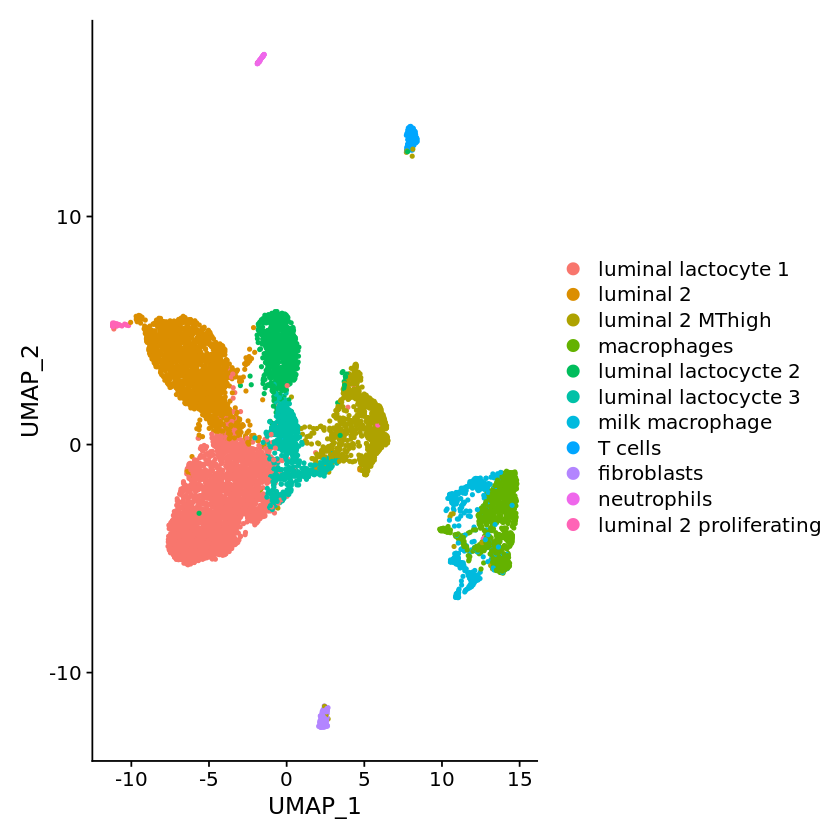

In [217]:
DimPlot(seurat.all.data, reduction = "umap", group.by = "cell_IDs", pt.size = 0.8)


In [244]:
cols.cells <- c("#5648A1","#9986A5","gray","#EE46A6","mediumpurple4","mediumpurple1","#E6A0C4",
              "#81A88D","#5eb668","#D8A499","lightcyan4")

#cols.cells <- c("#5648A1","#9986A5","#ffb6b6","#EE46A6","#780e0e","#bd1717","#E6A0C4","#81A88D","#5eb668",
#                "#D8A499","#ff5858")

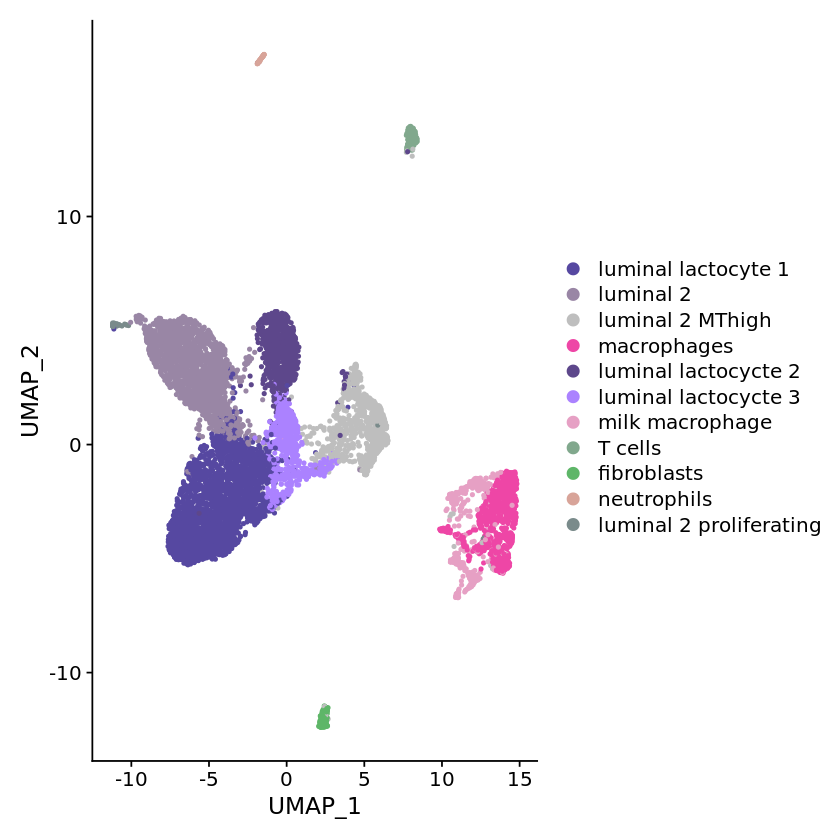

In [245]:
DimPlot(seurat.all.data, reduction = "umap", group.by = "cell_IDs", pt.size = 0.8, cols = cols.cells)


Saving 6.67 x 6.67 in image



character(0)

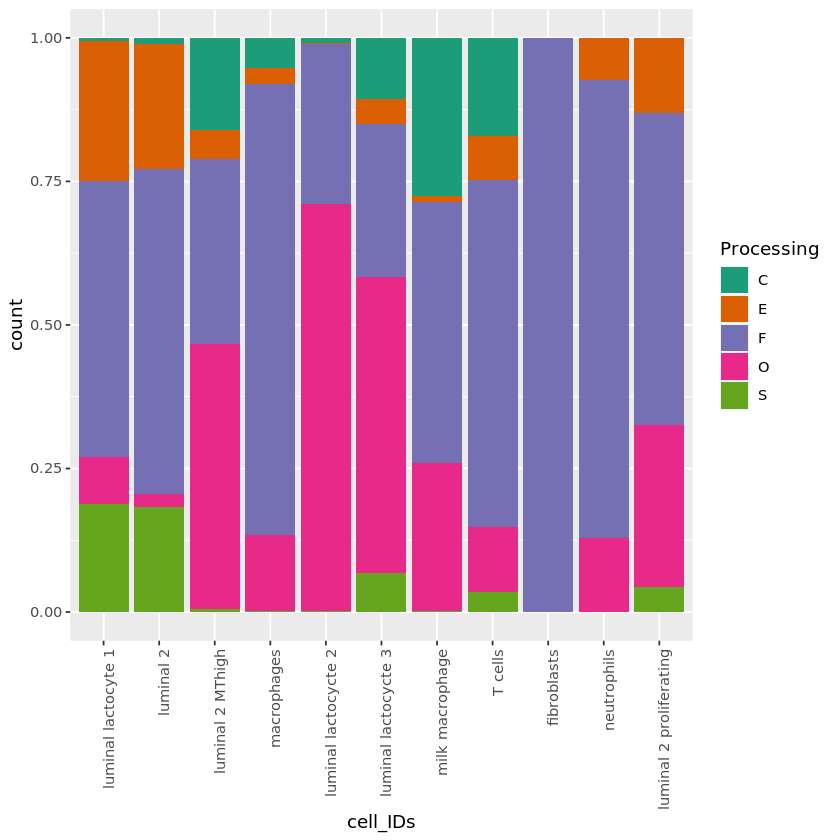

In [248]:
# cell type by processing
ggplot(seurat.all.data@meta.data, aes(x=cell_IDs, fill=Processing)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.processing) + theme(axis.text.x = element_text(angle = 90, hjust = 1))
ggsave("StackedBarClusters_CellID_Processing.pdf", useDingbats = F)
system(paste0("gsutil cp StackedBarClusters_CellID_Processing.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)




Saving 6.67 x 6.67 in image



character(0)

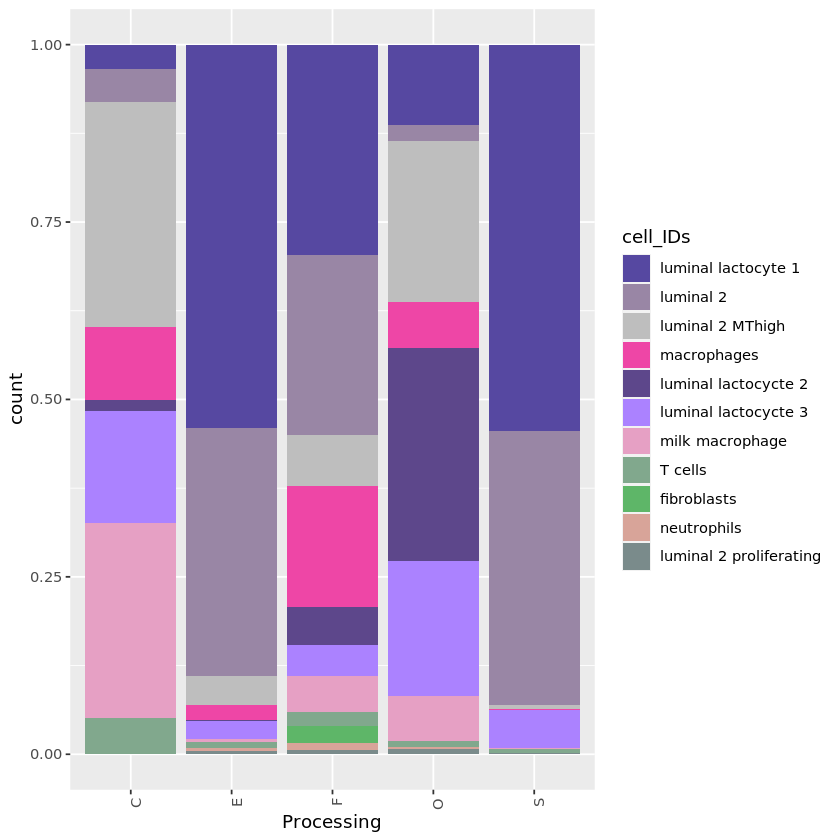

In [250]:
# processing by cell type
ggplot(seurat.all.data@meta.data, aes(x=Processing, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + theme(axis.text.x = element_text(angle = 90, hjust = 1))
ggsave("StackedBarClusters_Processing_CellType.pdf", useDingbats = F)
system(paste0("gsutil cp StackedBarClusters_Processing_CellType.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)


Saving 6.67 x 6.67 in image



character(0)

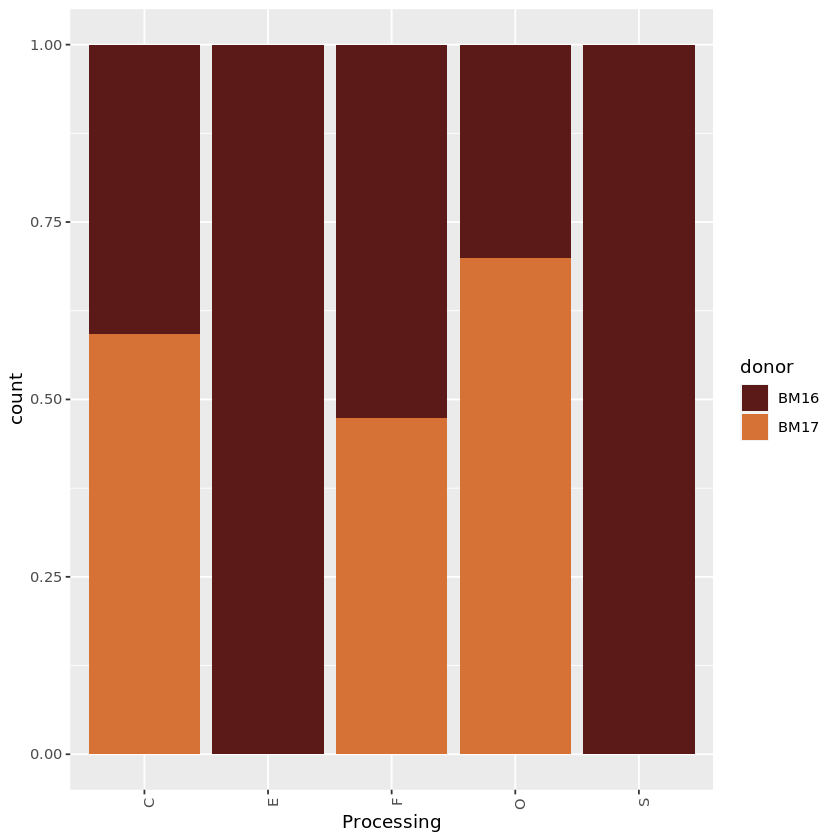

In [251]:
# processing by cell type
ggplot(seurat.all.data@meta.data, aes(x=Processing, fill=donor)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.donor) + theme(axis.text.x = element_text(angle = 90, hjust = 1))
ggsave("StackedBarClusters_Processing_Donor.pdf", useDingbats = F)
system(paste0("gsutil cp StackedBarClusters_Processing_Donor.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen/"), intern=TRUE)


# Fresh Replicates

In [253]:
head(seurat.all.data@meta.data)
unique(seurat.all.data@meta.data$ArrayName)

orig.ident     nCount_RNA nFeature_RNA
GCCTGGACTACT_BM16-C-R1-Exp1 hBM_processing 12480       311        
AAGATAAGGGCG_BM16-C-R1-Exp1 hBM_processing 33693      6844        
TAAATCGGTTAA_BM16-C-R1-Exp1 hBM_processing 37100      5717        
GTTGCCAACCAC_BM16-C-R1-Exp1 hBM_processing 36075      5835        
TAATGCTCTTGA_BM16-C-R1-Exp1 hBM_processing 31352      4892        
ACTAGTCCAGGG_BM16-C-R1-Exp1 hBM_processing 31564      6291        
                            ArrayName      Donor Processing Replicate
GCCTGGACTACT_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
AAGATAAGGGCG_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
TAAATCGGTTAA_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
GTTGCCAACCAC_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
TAATGCTCTTGA_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
ACTAGTCCAGGG_BM16-C-R1-Exp1 BM16-C-R1-Exp1 BM16  C          R1       
                            Experiment percent.mt RNA_snn_res.0.4
GCCTGGACTACT_BM16-C-R1-Exp1 Exp1       94.342949  7              
AAGATAAGGGCG_BM16-C-R1-Exp1 Exp1        2.751313  3              
TAAATCGGTTAA_BM16-C-R1-Exp1 Exp1        3.541779  3              
GTTGCCAACCAC_BM16-C-R1-Exp1 Exp1        1.948718  3              
TAATGCTCTTGA_BM16-C-R1-Exp1 Exp1        7.476397  9              
ACTAGTCCAGGG_BM16-C-R1-Exp1 Exp1        5.170447  3              
                            seurat_clusters RNA_snn_res.0.5 RNA_snn_res.0.6
GCCTGGACTACT_BM16-C-R1-Exp1 5               7               8              
AAGATAAGGGCG_BM16-C-R1-Exp1 2               3               3              
TAAATCGGTTAA_BM16-C-R1-Exp1 2               3               3              
GTTGCCAACCAC_BM16-C-R1-Exp1 2               3               3              
TAATGCTCTTGA_BM16-C-R1-Exp1 3               10              10             
ACTAGTCCAGGG_BM16-C-R1-Exp1 2               3               3              
                            RNA_snn_res.0.3 RNA_snn_res.0.2
GCCTGGACTACT_BM16-C-R1-Exp1 3               5              
AAGATAAGGGCG_BM16-C-R1-Exp1 3               2              
TAAATCGGTTAA_BM16-C-R1-Exp1 3               2              
GTTGCCAACCAC_BM16-C-R1-Exp1 3               2              
TAATGCTCTTGA_BM16-C-R1-Exp1 8               3              
ACTAGTCCAGGG_BM16-C-R1-Exp1 3               2              
                            cell_IDs            
GCCTGGACTACT_BM16-C-R1-Exp1 luminal lactocycte 3
AAGATAAGGGCG_BM16-C-R1-Exp1 luminal 2 MThigh    
TAAATCGGTTAA_BM16-C-R1-Exp1 luminal 2 MThigh    
GTTGCCAACCAC_BM16-C-R1-Exp1 luminal 2 MThigh    
TAATGCTCTTGA_BM16-C-R1-Exp1 macrophages         
ACTAGTCCAGGG_BM16-C-R1-Exp1 luminal 2 MThigh

[1] "BM16-C-R1-Exp1" "BM16-E-R1-Exp2" "BM16-F-R1-Exp1" "BM16-F-R1-Exp2"
 [5] "BM16-F-R2-Exp1" "BM16-O-R1-Exp1" "BM16-S-R1-Exp2" "BM17-C-R1-Exp1"
 [9] "BM17-F-R1-Exp1" "BM17-F-R1-Exp2" "BM17-F-R2-Exp1" "BM17-O-R1-Exp1"

In [257]:
Idents(object=seurat.all.data) <- "ArrayName"
seurat.all.data.replicates <- subset(seurat.all.data, idents = c("BM16-F-R2-Exp1","BM17-F-R2-Exp1","BM16-F-R1-Exp1", "BM17-F-R1-Exp1"))


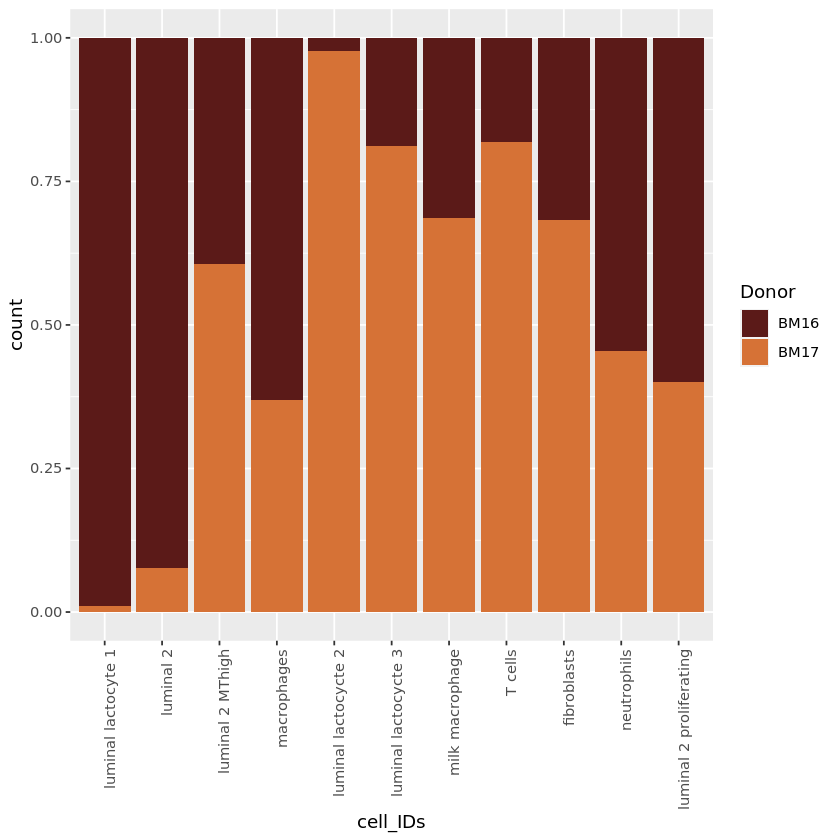

In [259]:
ggplot(seurat.all.data.replicates@meta.data, aes(x=cell_IDs, fill=Donor)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.donor) + theme(axis.text.x = element_text(angle = 90, hjust = 1))


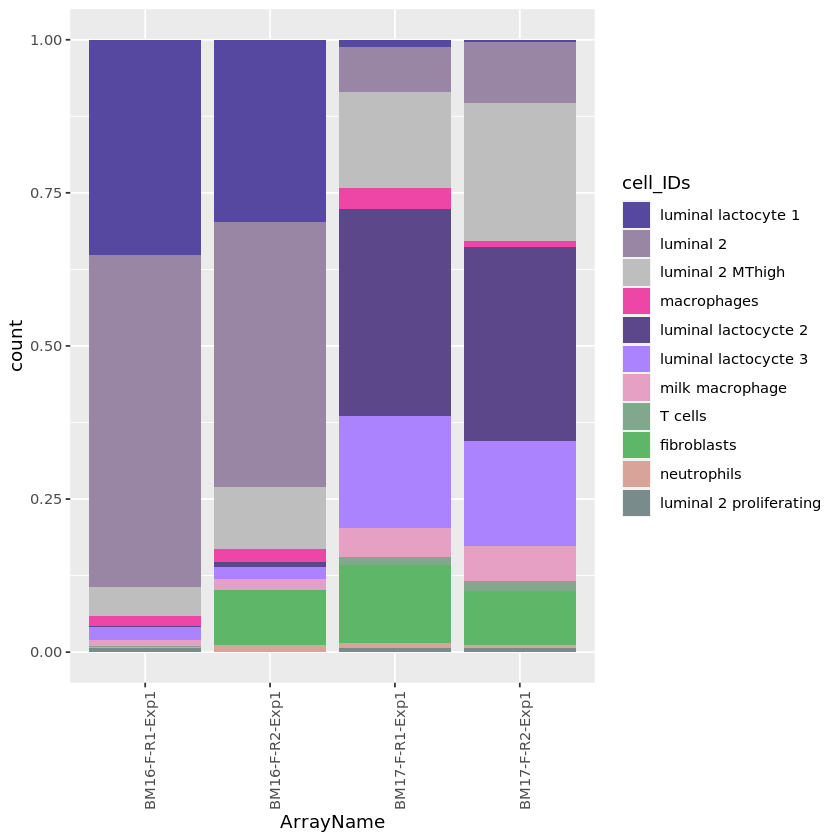

In [261]:
ggplot(seurat.all.data.replicates@meta.data, aes(x=ArrayName, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + theme(axis.text.x = element_text(angle = 90, hjust = 1))


# Fresh, Frozen, Overnight 

In [262]:
Idents(object=seurat.all.data) <- "ArrayName"
seurat.all.data.FFO.BM17 <- subset(seurat.all.data, idents = c("BM17-C-R1-Exp1","BM17-F-R1-Exp1","BM17-F-R2-Exp1","BM17-O-R1-Exp1"))
seurat.all.data.FFO.BM16 <- subset(seurat.all.data, idents = c("BM16-C-R1-Exp1","BM16-F-R1-Exp1","BM16-F-R2-Exp1","BM16-O-R1-Exp1"))


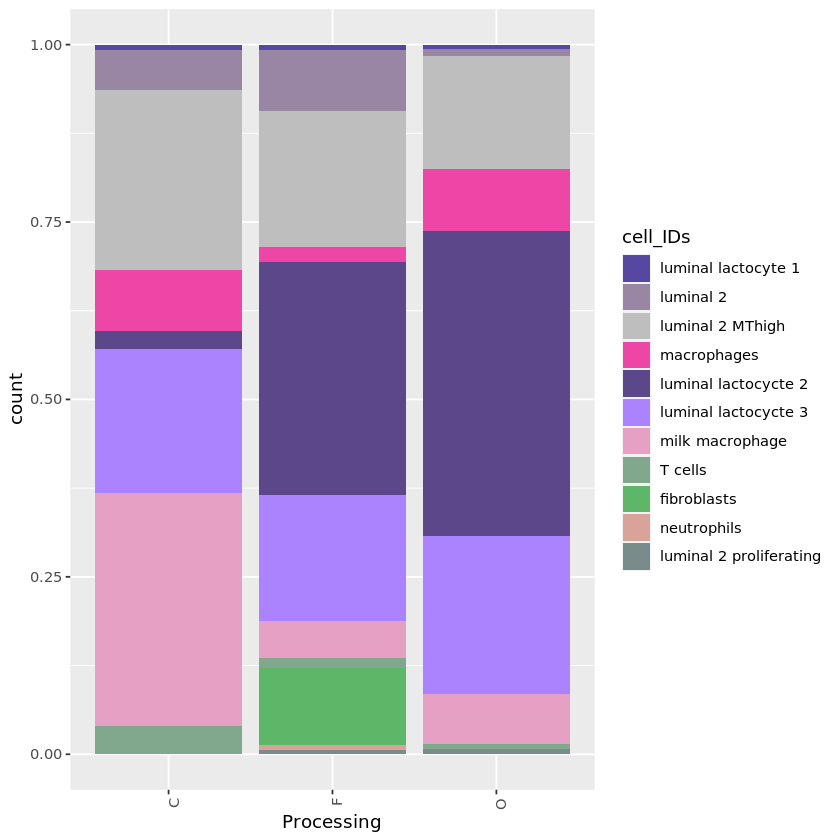

In [263]:
ggplot(seurat.all.data.FFO.BM17@meta.data, aes(x=Processing, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + theme(axis.text.x = element_text(angle = 90, hjust = 1))


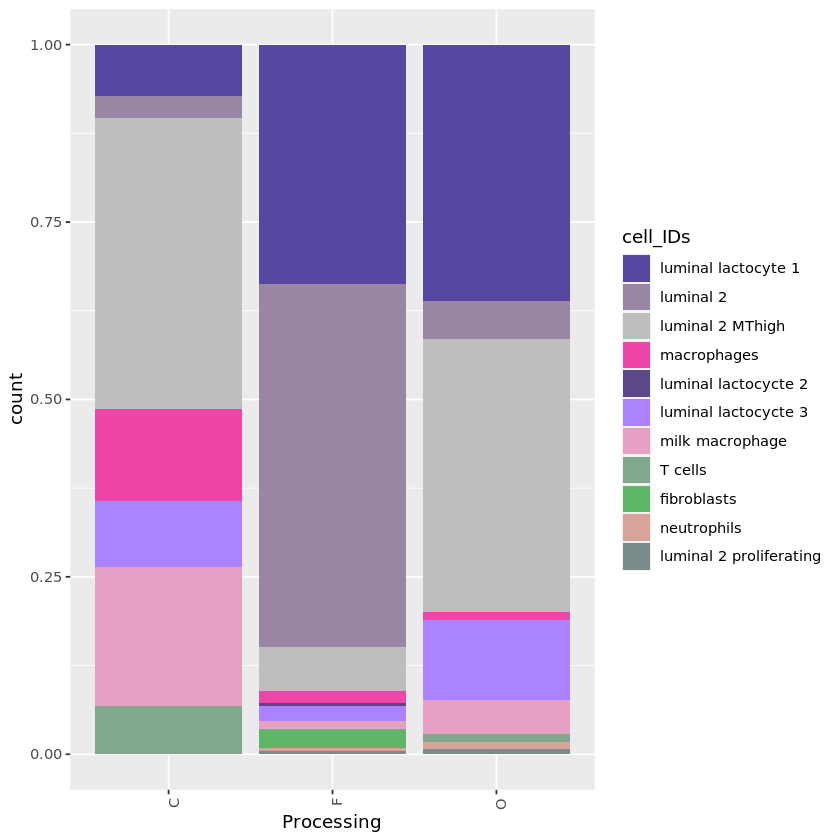

In [264]:
ggplot(seurat.all.data.FFO.BM16@meta.data, aes(x=Processing, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + theme(axis.text.x = element_text(angle = 90, hjust = 1))


# Fresh, Sort, Easysep 

In [265]:
Idents(object=seurat.all.data) <- "ArrayName"
seurat.all.data.Sort.BM17 <- subset(seurat.all.data, idents = c("BM16-S-R1-Exp2","BM16-F-R1-Exp2","BM16-E-R1-Exp2"))


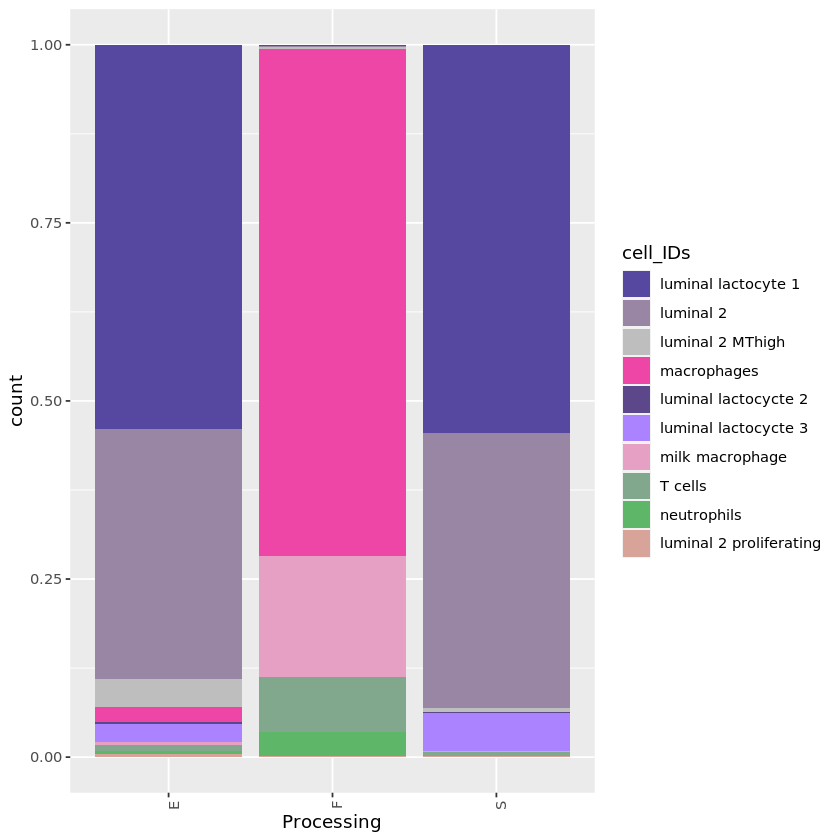

In [267]:
ggplot(seurat.all.data.Sort.BM17@meta.data, aes(x=Processing, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + theme(axis.text.x = element_text(angle = 90, hjust = 1))


# Make the figures!

In [273]:
panelA <- plot_grid(vlnMT + NoLegend(),vlncount+ NoLegend(), vlnfeat + NoLegend(), 
                    labels = c('A'), label_size = 14, nrow=1)

panelB <- plot_grid(pca.1P + NoLegend(),pca.2P+ NoLegend(), pca.3P + NoLegend(), 
          labels = c('B'), label_size = 14, nrow=1)

panelC  <- plot_grid(pca.1D + NoLegend(),pca.2D + NoLegend(), pca.3D + NoLegend(), 
          labels = c('C'), label_size = 14, nrow=1)

panelD <- plot_grid(pca.1D + NoLegend(),pca.2D + NoLegend(), pca.3D + NoLegend(), 
          labels = c('C'), label_size = 14, nrow=1)

character(0)

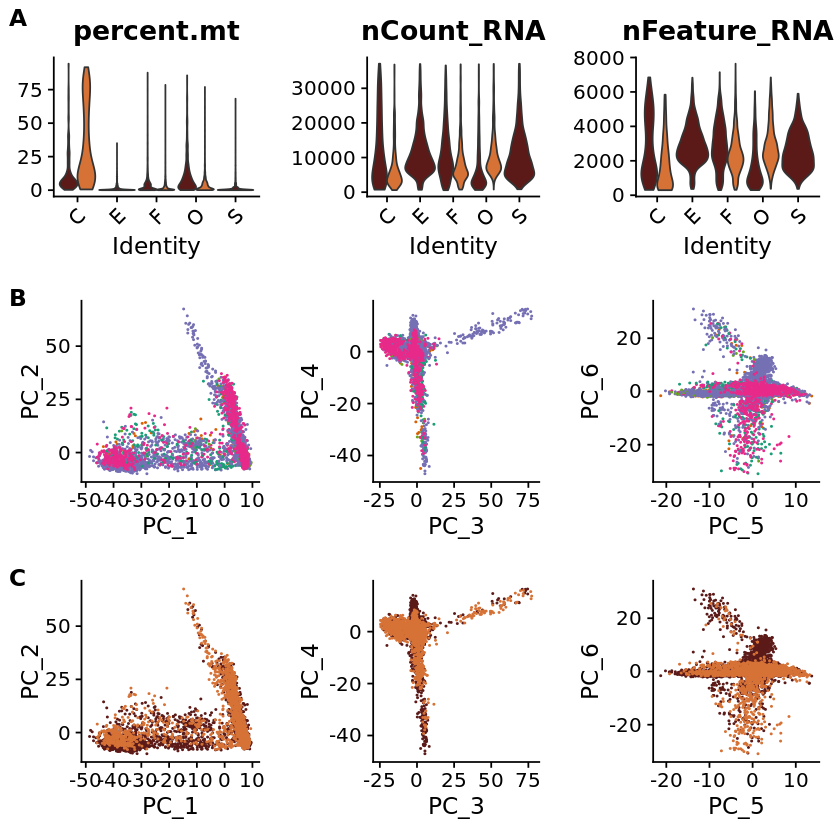

In [274]:
plot_grid(panelA,panelB,panelC, nrow=3)
ggsave("TechFigure.pdf", useDingbats = F, height = 8, width = 8, units = "in")
system(paste0("gsutil cp TechFigure.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen"), intern=TRUE)

In [268]:
umap.processing <- DimPlot(seurat.all.data, reduction = "umap", group.by = "Processing", pt.size = 0.8, cols = cols.processing)
umap.donor <- DimPlot(seurat.all.data, reduction = "umap", group.by = "Donor", pt.size = 0.8, cols = cols.donor)
umap.cells <- DimPlot(seurat.all.data, reduction = "umap", group.by = "cell_IDs", pt.size = 0.8, cols = cols.cells)


In [275]:
panelB.2 <- plot_grid(umap.processing + NoLegend(),umap.donor+ NoLegend(), umap.cells + NoLegend(), labels = c('B'), label_size = 14, nrow=1)


In [278]:
stacked.replicates <- ggplot(seurat.all.data.replicates@meta.data, aes(x=ArrayName, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + NoLegend()
stacked.FFO.BM17 <- ggplot(seurat.all.data.FFO.BM17@meta.data, aes(x=Processing, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + theme(axis.text.x = element_text(angle = 90, hjust = 1))+ NoLegend()
stacked.FFO.BM16 <- ggplot(seurat.all.data.FFO.BM16@meta.data, aes(x=Processing, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + theme(axis.text.x = element_text(angle = 90, hjust = 1))+ NoLegend()
stacked.Sort.BM17 <- ggplot(seurat.all.data.Sort.BM17@meta.data, aes(x=Processing, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + theme(axis.text.x = element_text(angle = 90, hjust = 1))+ NoLegend()


In [281]:
panelC.2 <- plot_grid(stacked.replicates,stacked.FFO.BM16,stacked.FFO.BM16,stacked.Sort.BM17, labels = c('C'), label_size = 14, nrow=1)


character(0)

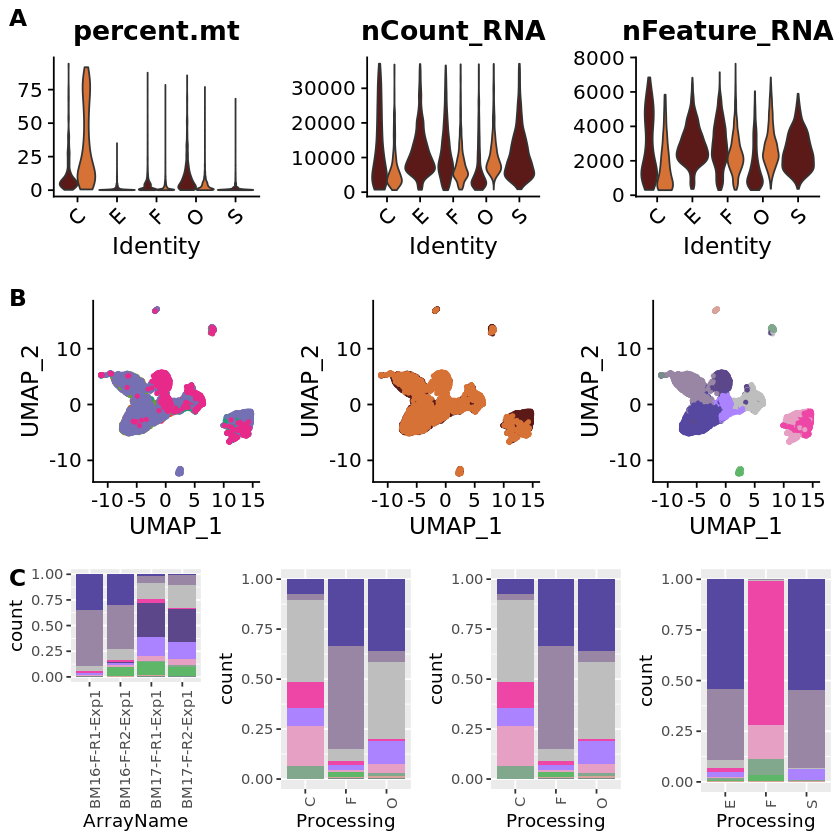

In [282]:
plot_grid(panelA,panelB.2,panelC.2, nrow=3)
ggsave("TechFigure_2.pdf", useDingbats = F, height = 8, width = 8, units = "in")
system(paste0("gsutil cp TechFigure_2.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen"), intern=TRUE)

In [290]:
stacked.replicates.noX <- ggplot(seurat.all.data.replicates@meta.data, aes(x=ArrayName, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + NoLegend() + theme(axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank())
stacked.FFO.BM17.noX <- ggplot(seurat.all.data.FFO.BM17@meta.data, aes(x=Processing, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + NoLegend() + theme(axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank())
stacked.FFO.BM16.noX <- ggplot(seurat.all.data.FFO.BM16@meta.data, aes(x=Processing, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + NoLegend() + theme(axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank())
stacked.Sort.BM17.noX <- ggplot(seurat.all.data.Sort.BM17@meta.data, aes(x=Processing, fill=cell_IDs)) + geom_bar(position = "fill") + scale_fill_manual(values=cols.cells) + NoLegend() + theme(axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank())


In [291]:
panelC.2.noX <- plot_grid(stacked.replicates.noX,stacked.FFO.BM16.noX,stacked.FFO.BM17.noX,stacked.Sort.BM17.noX, labels = c('C'), label_size = 14, nrow=1)


character(0)

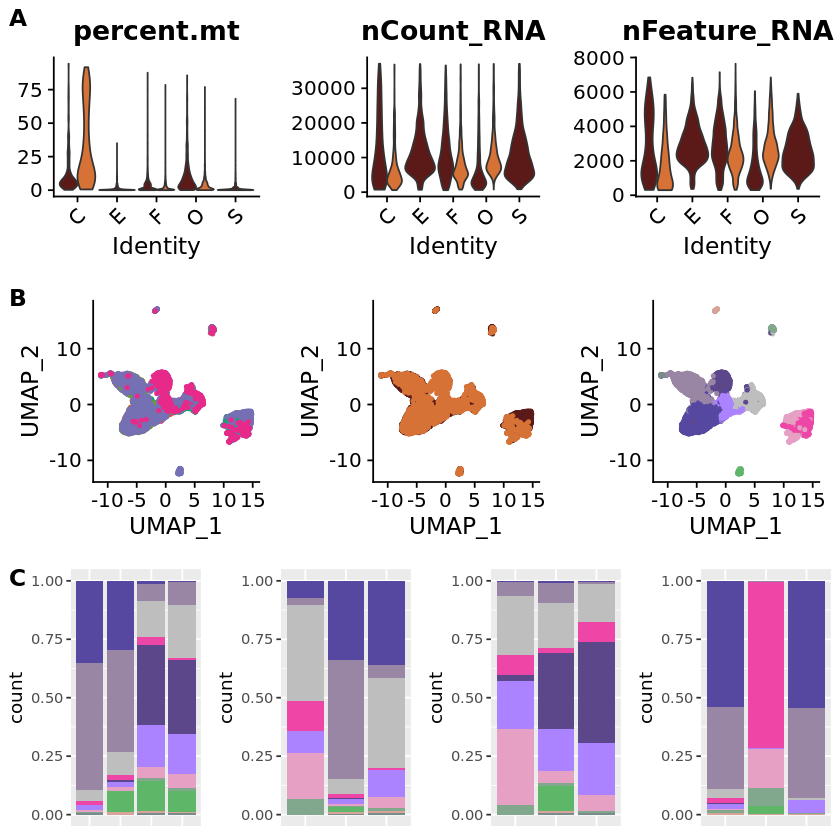

In [292]:
plot_grid(panelA,panelB.2,panelC.2.noX, nrow=3)
ggsave("TechFigure_2_noX.pdf", useDingbats = F, height = 8, width = 8, units = "in")
system(paste0("gsutil cp TechFigure_2_noX.pdf gs://fc-943d6020-b7d7-4091-b0d4-51cc6cb7617e/FreshvFrozen"), intern=TRUE)